### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points.

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


Code from previous notebook

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv("/kaggle/input/job-salary-prediction/Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

(array([  447.,   267.,   521.,   617.,  5549., 13073., 19631., 22836.,
        33116., 35581., 36991., 28050., 16408., 17527.,  7096.,  5505.,
         1309.,   135.,    64.,    45.]),
 array([ 8.51739311,  8.70182705,  8.88626194,  9.07069588,  9.25512981,
         9.43956375,  9.62399864,  9.80843258,  9.99286652, 10.17730141,
        10.36173534, 10.54616928, 10.73060417, 10.91503811, 11.09947205,
        11.28390694, 11.46834087, 11.65277481, 11.83720875, 12.02164364,
        12.20607758]),
 <BarContainer object of 20 artists>)

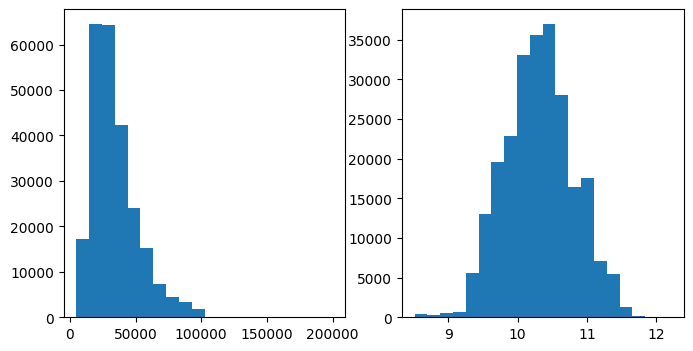

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
100315,69539810,Sales/Administrator Nights,Our client are looking for somebody with excep...,"North London, London",North London,NaN,permanent,Grow Recruitment,Sales Jobs,"15000 - 21000/annum 15-21,000",18000,cv-library.co.uk,9.798182
44872,68514828,Senior Chef de Partie Fine Dining Restaurant W...,Senior Chef de Partie Fine Dining Restaurant W...,West Sussex South East,West Sussex,NaN,NaN,Chef Selection Limited,Hospitality & Catering Jobs,"Up to 21,000 per annum 21k Plus Tips",21000,caterer.com,9.952325
203132,71903660,IFA Compliance Assistant,IFA Compliance Assistant pound;**** London nbs...,London,London,NaN,permanent,Coast Specialist Recruitment,Accounting & Finance Jobs,"35-45,000",40000,ifaonlinejobs.co.uk,10.596660


In [7]:
import nltk

for text_column in text_columns:
    data[text_column] = data[text_column].fillna('NaN')

tokenizer = nltk.tokenize.WordPunctTokenizer()

for text_column in text_columns:
    data[text_column] = data[text_column].apply(lambda text: " ".join(tokenizer.tokenize(text.lower())))

In [8]:
from collections import Counter
token_counts = Counter()

for text_column in text_columns:
    for text in data[text_column]:
        token_counts.update(text.split())

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count) #TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = {token : index for index, token in enumerate(tokens)}

In [10]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [11]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [12]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [13]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 10

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [15]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]], device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

Let's first follow advice (E) and rewrite training loop
This will allow us
1. Perform early stopping
2. Save best model and use it later 
3. Print learning plots

We will use some code from ML-2 course and previous notebook and refactor it for our needs

In [16]:
import os
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta

In [17]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

In [18]:
def train(model, optimizer, criterion, batch_size=BATCH_SIZE):
    model.train()
    losses_tr = []
    for i, batch in tqdm(enumerate(
        iterate_minibatches(data_train, batch_size=batch_size, device=device)),
                         total=len(data_train) // batch_size):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_tr.append(loss.item())
    return model, optimizer, np.mean(losses_tr)

In [19]:
def validate(model, batch_size=BATCH_SIZE, device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()

    with torch.no_grad():
        for i, batch in tqdm(enumerate(
            iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw)),
                             total=len(data) // batch_size):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)

    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)

    return mse, mae

In [20]:
def training_loop(
    model,
    optimizer,
    epochs=10,
    val_every=1,
    draw_every=1,
    model_name=None,
    chkp_folder="./chkps",
    mae_delta_to_stop=None,
    stop_on_mae_increase=False,
    conscecutive_drops=2
):
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        model_name += "#0"

    best_val_mae = np.Inf
    curr_val_mae, curr_val_mse = None, None
    accuracy_drops = 0
    losses = {
        "train": [],
        "test": {
              "mse": [],
              "mae": [],
        }
    }

    start_time = time.monotonic()
    criterion = nn.MSELoss(reduction='sum')

    for epoch in range(1, epochs + 1):
        print(f'#{epoch}/{epochs}:')

        model, optimizer, loss = train(model, optimizer, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            mse, mae = validate(model, device=device)
            curr_val_mae = mae
            curr_val_mse = mse
            losses['test']['mse'].append(mse)
            losses['test']['mae'].append(mae)

        if mae < best_val_mae:
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'losses': losses,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )
            best_val_mae = mae
            accuracy_drops = 0
        else:
            if stop_on_mae_increase:
                accuracy_drops += 1
                if accuracy_drops >= conscecutive_drops:
                    break

        if mae_delta_to_stop:
            if abs(best_val_mae - mae) < mae_delta_to_stop:
                break

        if not (epoch % draw_every):
            clear_output(True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
            fig.suptitle(f'{model_name} #{epoch}/{epochs} ~ {timedelta(seconds=time.monotonic() - start_time)} ~ mae: {curr_val_mae:.4f}, mse: {curr_val_mse:.4f}')

            ax1.plot(losses['train'], 'r.-', label='train')
            ax2.plot(losses['test']['mse'], 'g.-', label='val_mse')
            ax2.plot(losses['test']['mae'], 'b.-', label='val_mae')
            ax1.legend()
            ax2.legend()
            ax1.grid()
            ax2.grid()

            plt.show()
    return losses

Let's also rewrite encoder classes to allow us to perform experiments more easily

In [21]:
class MaxOverTimePooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, weights, *args, **kwargs):
        return weights.max(dim=-1).values

In [22]:
class ConvLayer(nn.Module):
    def __init__(
        self, 
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        padding="same",
        activation_class=nn.ReLU,
        pooling_class=MaxOverTimePooling,
        use_bn=False,
        p_dropout=0
    ):
        super().__init__()
        
        self.conv = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding
        )
        self.bn = nn.BatchNorm1d(num_features=out_channels) if use_bn else nn.Identity()
        self.activation = activation_class()
        self.dropout = nn.Dropout(p=p_dropout)
        self.pool = pooling_class()
        
    def forward(self, batch, *args, **kwargs):
        x = self.conv(batch)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.pool(x, batch)
        return x

In [23]:
class TextEncoder(nn.Module):
    def __init__(
        self, 
        n_tokens=len(tokens),
        embedding_dim=100,
        out_channels=128,
        kernel_size=3,
        padding="same",
        activation_class=nn.ReLU,
        pooling_class=MaxOverTimePooling,
        use_bn=False,
        p_dropout=0
    ):
        super().__init__()

        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=embedding_dim,
            padding_idx=PAD_IX
        )
        self.conv = ConvLayer(
            in_channels=embedding_dim, 
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            activation_class=activation_class,
            pooling_class=pooling_class,
            use_bn=use_bn,
            p_dropout=p_dropout
        )

    def forward(self, batch, *args, **kwargs):
        emb = self.emb(batch).swapaxes(1, 2)
        x = self.conv(emb)
        return x

In [24]:
class CategoricalEncoder(nn.Module):
    def __init__(
        self, 
        input_size=len(categorical_vectorizer.vocabulary_), 
        hid_size=256, 
        output_size=128,
        activation_class=nn.ReLU,
        use_bn=False,
        p_dropout=0
    ):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hid_size)
        self.bn = nn.BatchNorm1d(hid_size) if use_bn else nn.Identity()
        self.activation = activation_class()
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(hid_size, output_size)

    def forward(self, batch):
        x = self.fc1(batch)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [25]:
class SalaryPredictor(nn.Module):
    def __init__(
        self,
        title_encoder_class,
        title_encoder_params,
        description_encoder_class,
        description_encoder_params,
        categorical_encoder_class,
        categorical_encoder_params,
        input_size,
        hid_size,
        activation_class=nn.ReLU,
        use_bn=False,
        p_dropout=0,
        use_same_embeddings=False
    ):
        super().__init__()
        self.title_encoder = title_encoder_class(**title_encoder_params)
        self.description_encoder = description_encoder_class(**description_encoder_params)
        self.categorical_encoder = categorical_encoder_class(**categorical_encoder_params)
        
        if use_same_embeddings:
            self.description_encoder.emb = self.title_encoder.emb
        
        self.fc1 = nn.Linear(input_size, hid_size)
        self.bn = nn.BatchNorm1d(hid_size) if use_bn else nn.Identity()
        self.dropout = nn.Dropout(p=p_dropout)
        self.activation = activation_class()
        self.fc2 = nn.Linear(hid_size, 1)


    def forward(self, batch):
        encoded_title = self.title_encoder(batch['Title'])
        encoded_description = self.description_encoder(batch['FullDescription'])
        encoded_categorical_features = self.categorical_encoder(batch['Categorical'])
        x = torch.cat([
            encoded_title,
            encoded_description,
            encoded_categorical_features
        ], dim=-1)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x.squeeze()

In [26]:
def create_mode_and_optimizer(model_class, model_params, use_adam=False):
    model = model_class(**model_params)
    model = model.to(device)

    params = []
    for param in model.parameters():
        if param.requires_grad:
            params.append(param)
    
    if use_adam:
        optimizer = torch.optim.SGD(params, lr=1e-4)
    else:
        optimizer = torch.optim.Adam(params, 1e-3, [0.9, 0.999])
    return model, optimizer

In [27]:
default_title_encoder_params = {
    'n_tokens': len(tokens),
    'embedding_dim' : 100,
    'out_channels': 128,
    'kernel_size': 3,
    'padding': "same",
    'activation_class': nn.ReLU,
    'pooling_class': MaxOverTimePooling,
    'use_bn': False,
    'p_dropout': 0
}
default_description_encoder_params = {
    'n_tokens': len(tokens),
    'embedding_dim' : 100,
    'out_channels': 128,
    'kernel_size': 3,
    'padding': "same",
    'activation_class': nn.ReLU,
    'pooling_class': MaxOverTimePooling,
    'use_bn': False,
    'p_dropout': 0
}
default_categorical_encoder_params = {
    'input_size' : len(categorical_vectorizer.vocabulary_), 
    'hid_size' : 256, 
    'output_size' : 128,
    'activation_class' : nn.ReLU,
    'use_bn': False,
    'p_dropout': 0
}
default_model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": default_title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": default_description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": default_categorical_encoder_params,
    "input_size": (
        default_title_encoder_params.get("out_channels", 128) + 
        default_description_encoder_params.get("out_channels", 128) + 
        default_categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

**Experiment 1**

SGD vs Adam optimizer

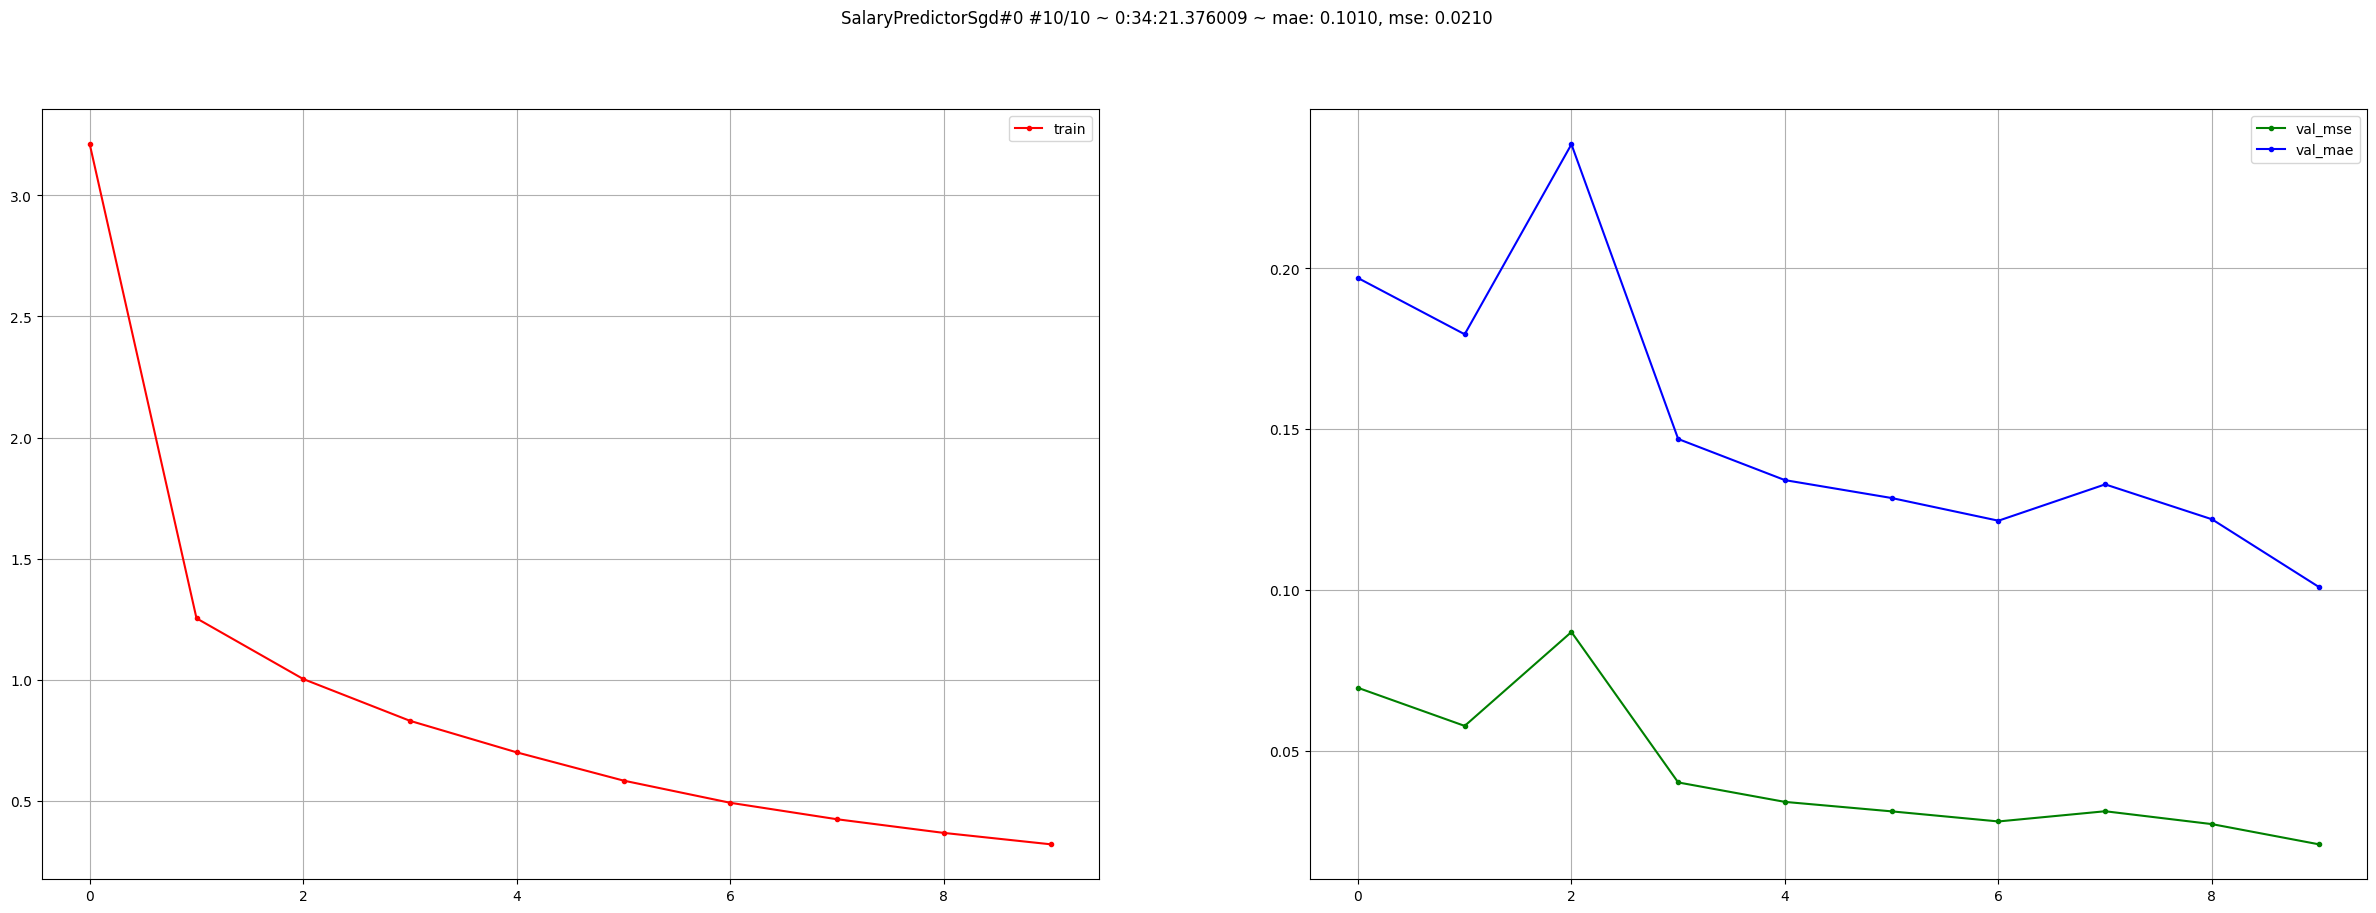

In [26]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    default_model_params
)
sgd_losses = training_loop(model, optimizer, model_name="SalaryPredictorSgd")

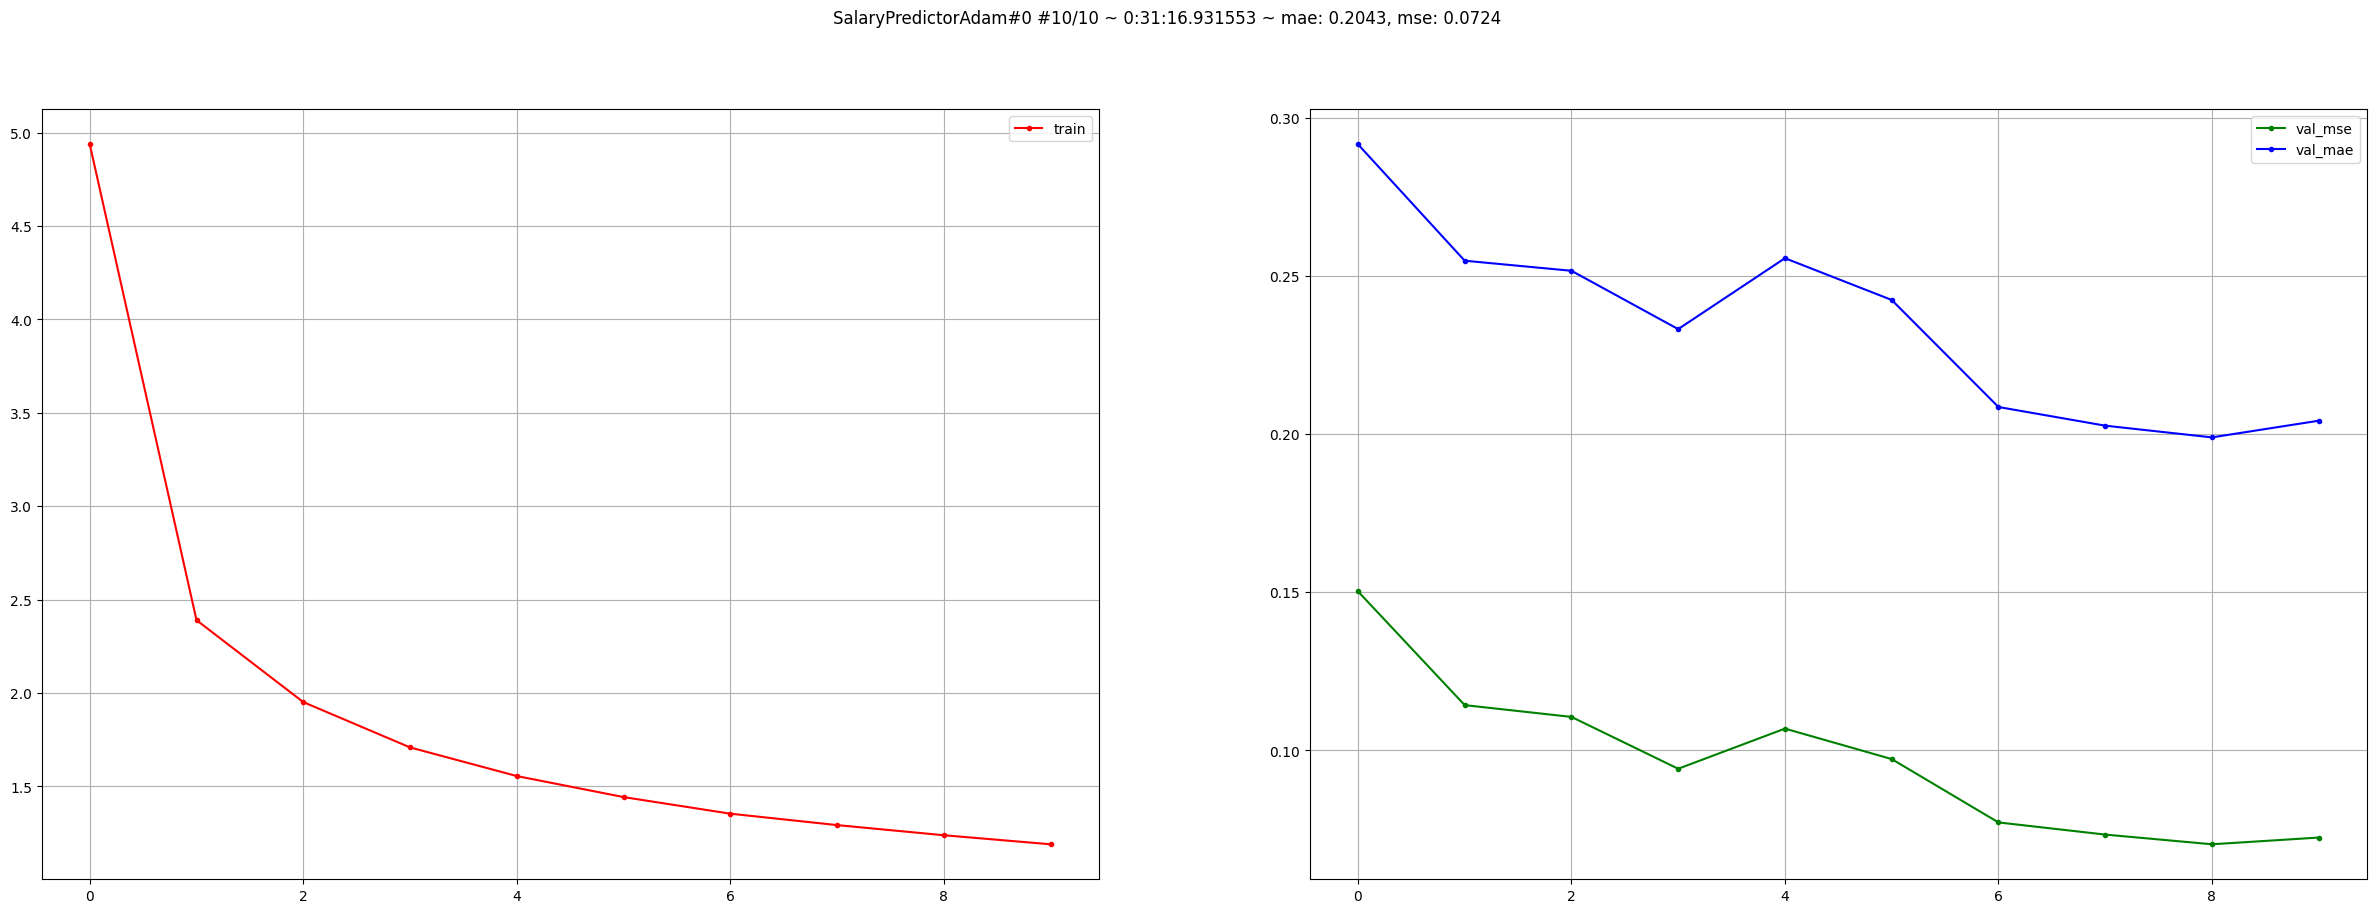

In [27]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    default_model_params,
    use_adam=True
)
adam_losses = training_loop(model, optimizer, model_name="SalaryPredictorAdam")

Let's plot two experiments together

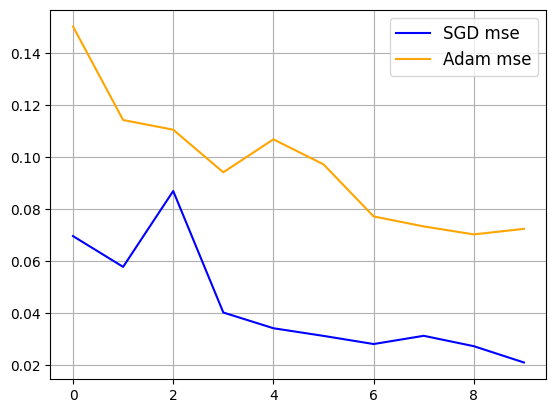

In [28]:
plt.plot(sgd_losses['test']['mse'], label='SGD mse', color='b')
plt.plot(adam_losses['test']['mse'], label='Adam mse', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

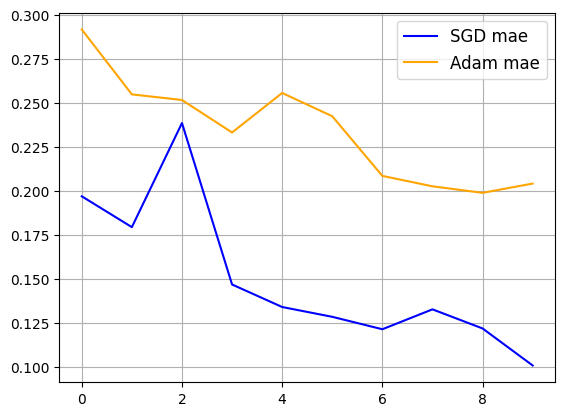

In [29]:
plt.plot(sgd_losses['test']['mae'], label='SGD mae', color='b')
plt.plot(adam_losses['test']['mae'], label='Adam mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

Comparing by 10 epochs we can see that SGD learning plots are a lot more noisy. But it achieves greater accuracy. So we will use SGD in all future experiments as the baseline

**Experiment 2**

a) CNN dropout

b) Linear layer dropout

In [30]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['p_dropout'] = 0.3

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['p_dropout'] = 0.3

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channels", 128) + 
        description_encoder_params.get("out_channels", 128) + 
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

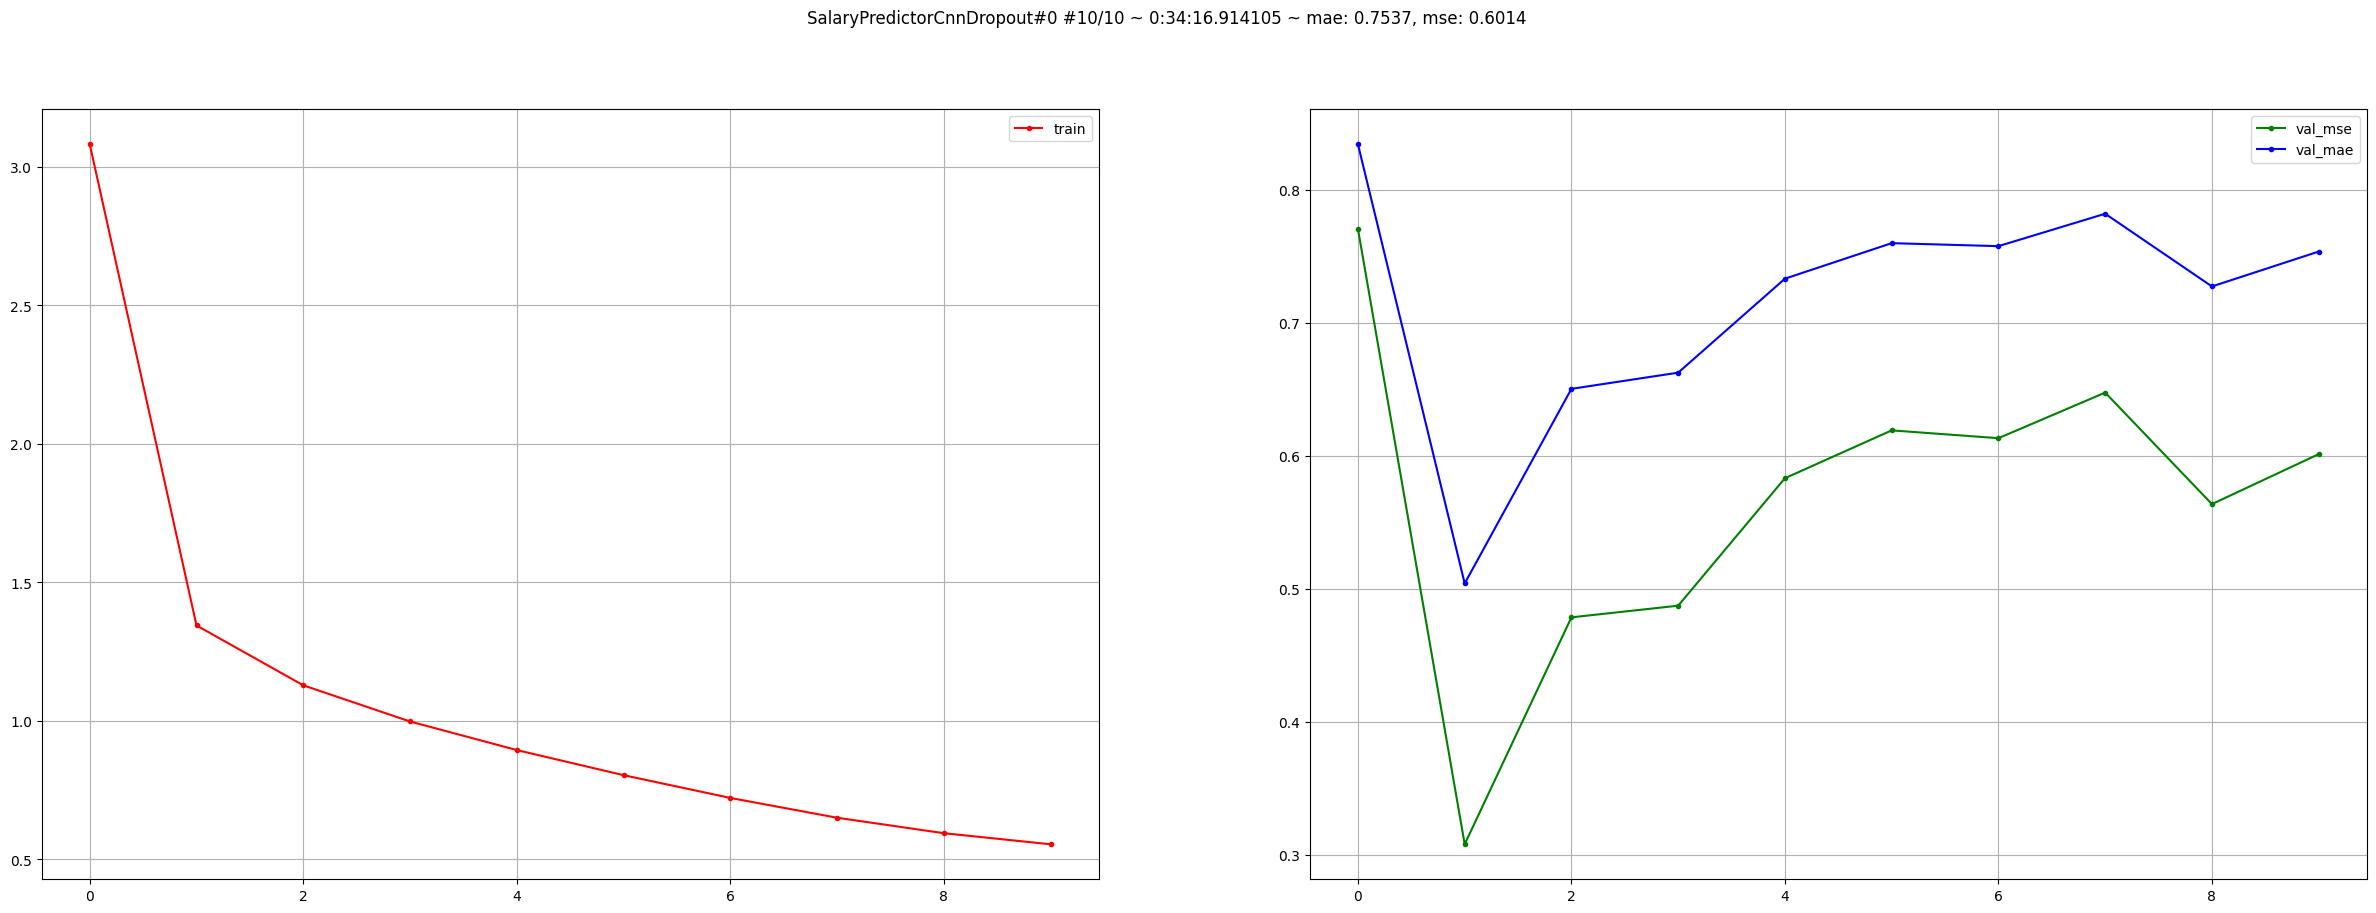

In [31]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
cnn_dropout_losses = training_loop(model, optimizer, model_name="SalaryPredictorCnnDropout")

In [32]:
title_encoder_params = {
    **default_title_encoder_params
}

description_encoder_params = {
    **default_description_encoder_params
}

categorical_encoder_params = {
    **default_categorical_encoder_params
}
categorical_encoder_params['p_dropout'] = 0.3

model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channels", 128) + 
        description_encoder_params.get("out_channels", 128) + 
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0.3,
    "use_same_embeddings": False
}

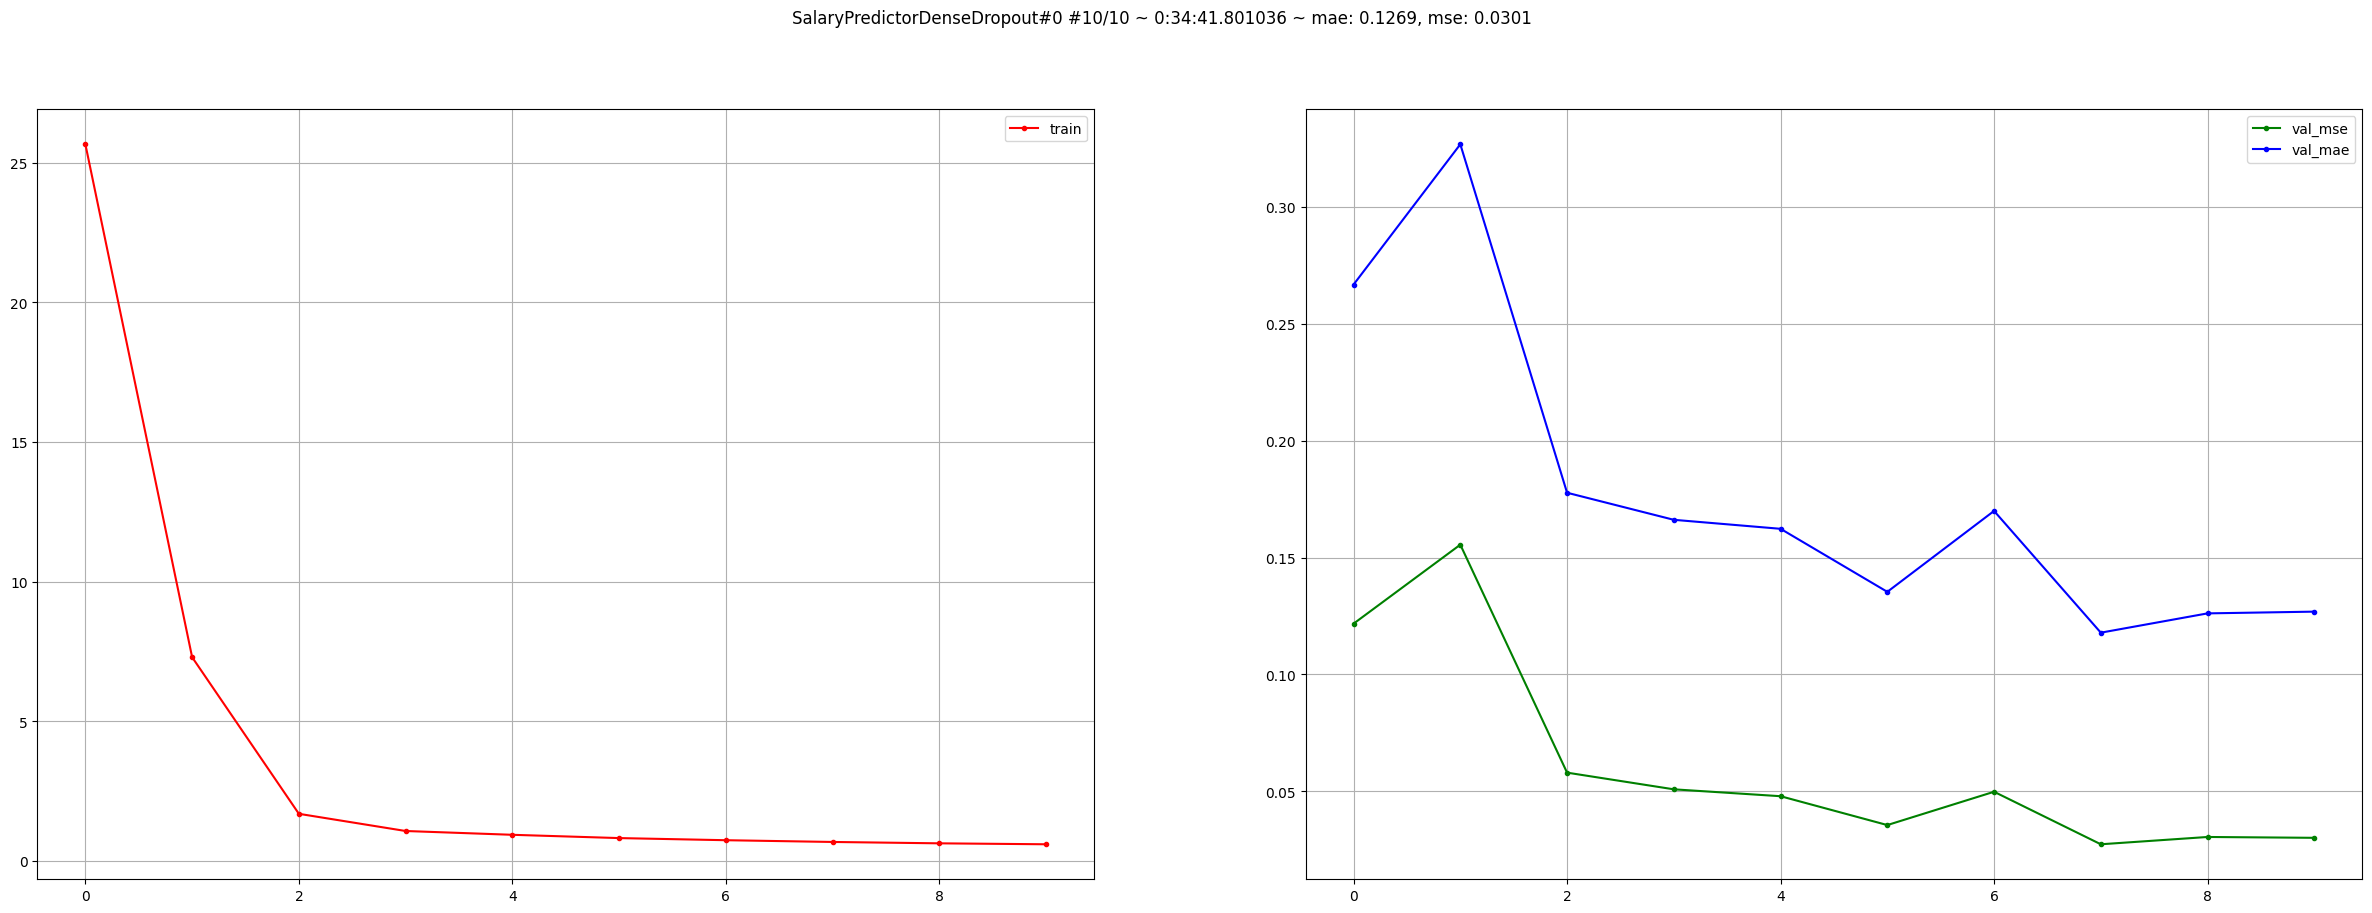

In [33]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
dense_dropout_losses = training_loop(model, optimizer, model_name="SalaryPredictorDenseDropout")

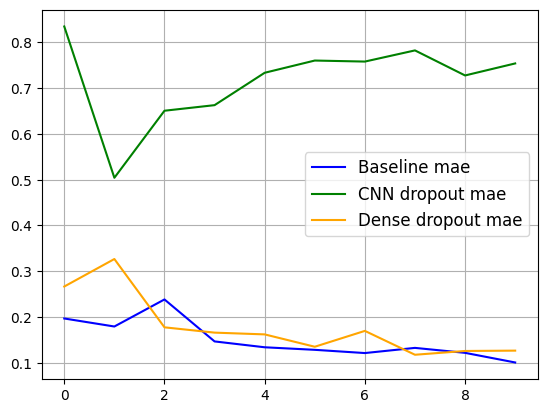

In [34]:
plt.plot(sgd_losses['test']['mae'], label='Baseline mae', color='b')
plt.plot(cnn_dropout_losses['test']['mae'], label='CNN dropout mae', color='g')
plt.plot(dense_dropout_losses['test']['mae'], label='Dense dropout mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

Using dropout in CNN was not a great idea

Using dropout in Dense layer is good enough. Though we haven't seen significant boost in mae, if we've used network with more layers and parameters and trained it longer, dropout could have helped us to avoid overfitting 

**Experiment 3**

a) CNN BN

b) Dense BN

In [35]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['use_bn'] = True

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['use_bn'] = True

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channels", 128) + 
        description_encoder_params.get("out_channels", 128) + 
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

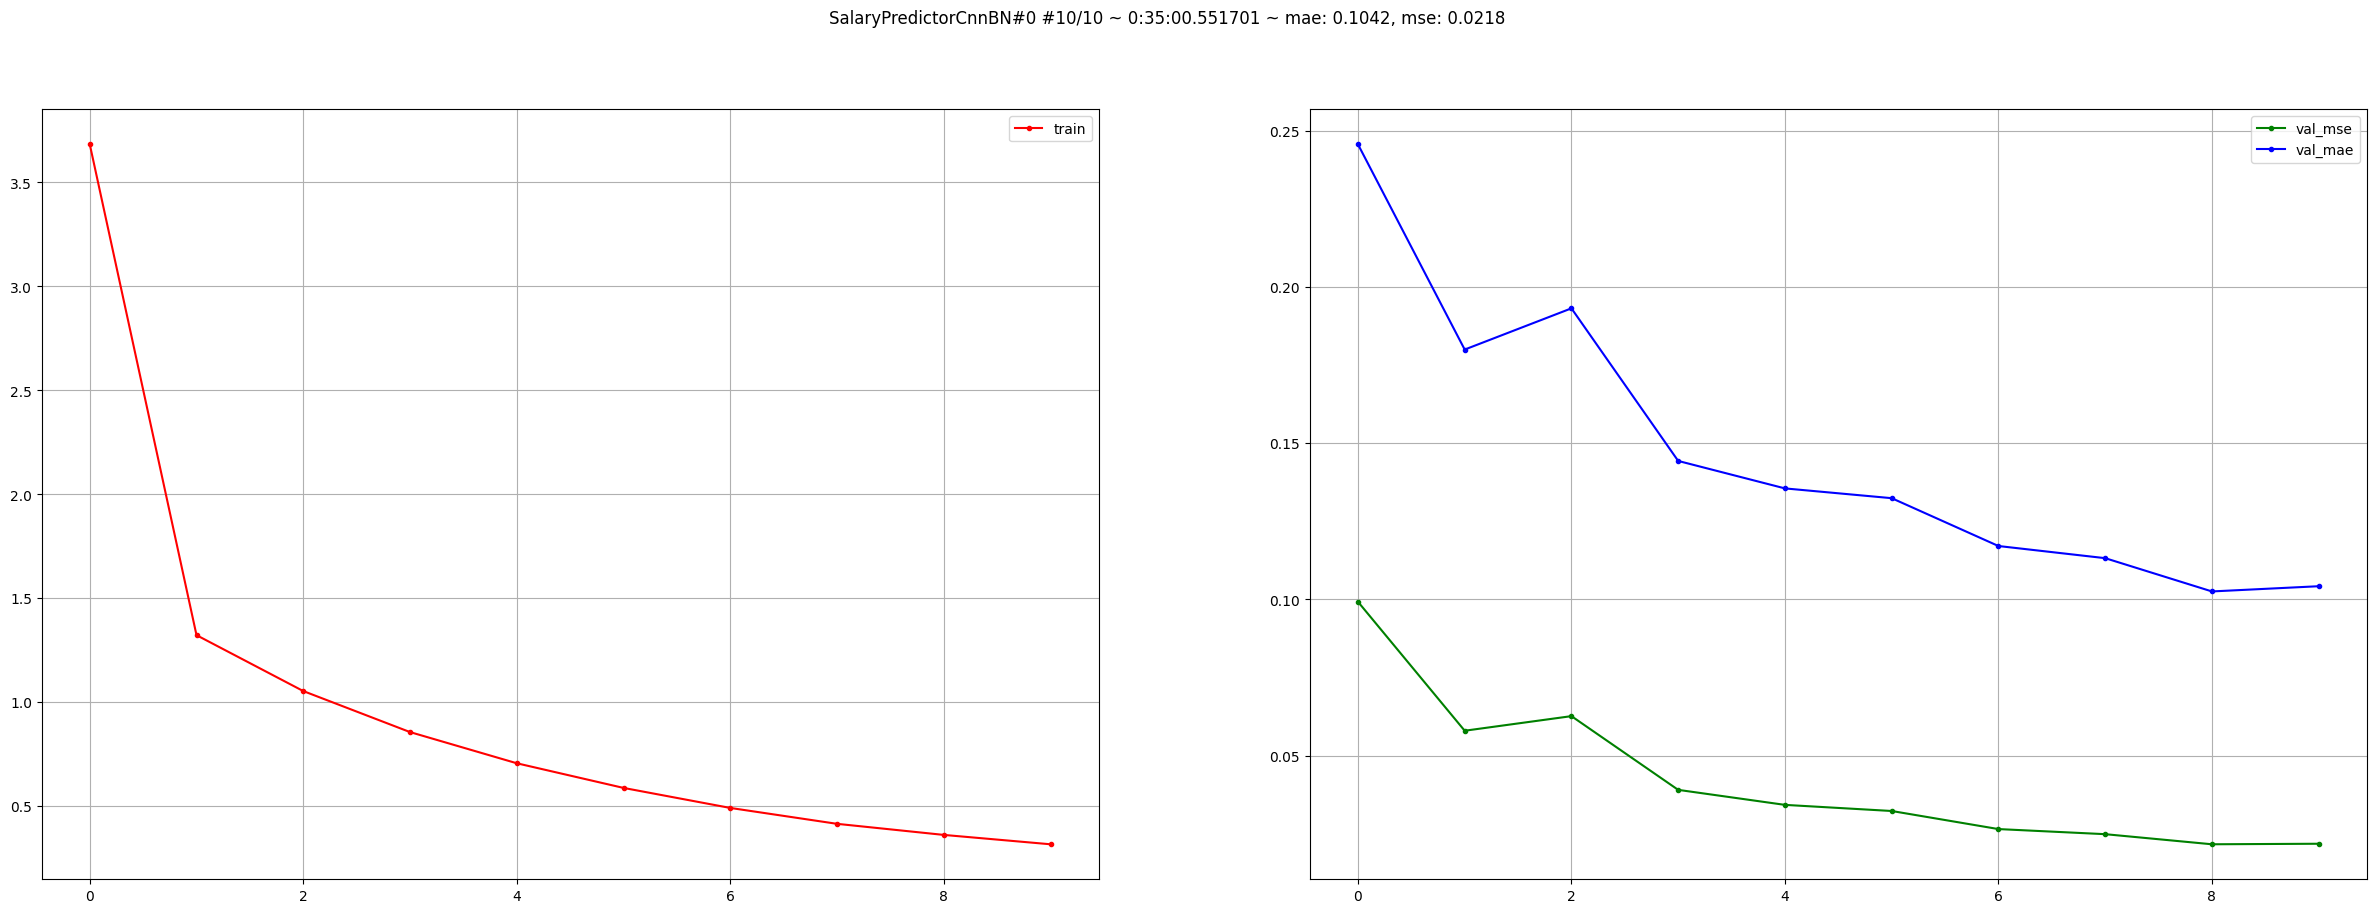

In [36]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
cnn_bn_losses = training_loop(model, optimizer, model_name="SalaryPredictorCnnBN")

In [37]:
title_encoder_params = {
    **default_title_encoder_params
}

description_encoder_params = {
    **default_description_encoder_params
}

categorical_encoder_params = {
    **default_categorical_encoder_params
}
categorical_encoder_params['use_bn'] = True

model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channels", 128) + 
        description_encoder_params.get("out_channels", 128) + 
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : True,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

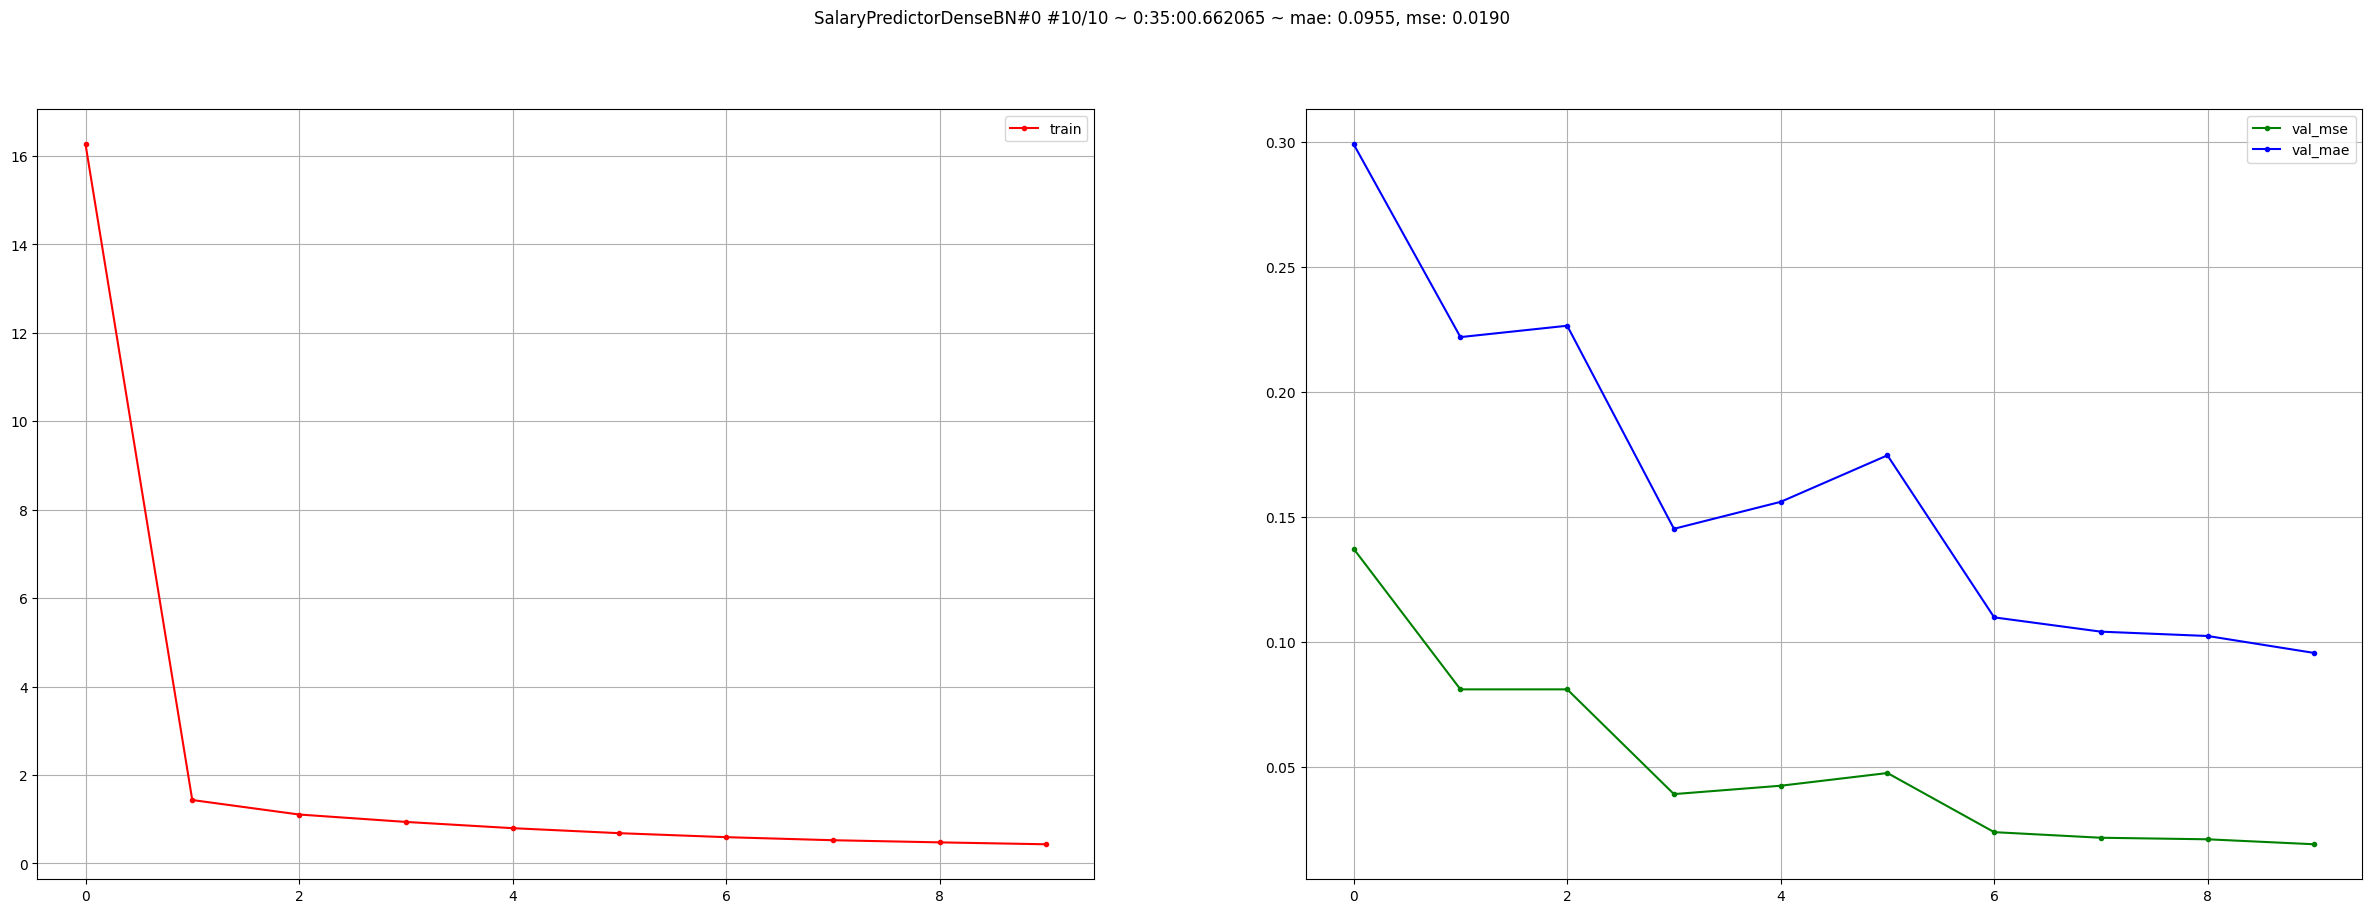

In [38]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
dense_bn_losses = training_loop(model, optimizer, model_name="SalaryPredictorDenseBN")

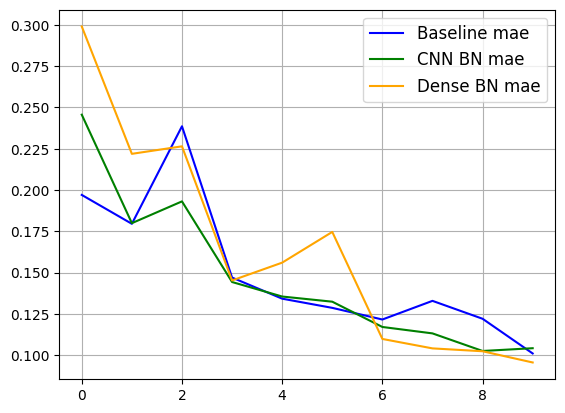

In [43]:
plt.plot(sgd_losses['test']['mae'], label='Baseline mae', color='b')
plt.plot(cnn_bn_losses['test']['mae'], label='CNN BN mae', color='g')
plt.plot(dense_bn_losses['test']['mae'], label='Dense BN mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

Unlike dropout, batch normalization gave positive results both for CNN and Dense layers

**Experiment 4**

Parallel convolutions

In [44]:
class TextEncoderParallel(nn.Module):
    def __init__(
        self, 
        n_tokens=len(tokens),
        embedding_dim=100,
        out_channels=128,
        kernel_size=3,
        padding="same",
        activation_class=nn.ReLU,
        pooling_class=MaxOverTimePooling,
        use_bn=False,
        p_dropout=0
    ):
        super().__init__()

        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=embedding_dim,
            padding_idx=PAD_IX
        )
        self.conv1 = ConvLayer(
            in_channels=embedding_dim, 
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            activation_class=activation_class,
            pooling_class=pooling_class,
            use_bn=use_bn,
            p_dropout=p_dropout
        )
        self.conv2 = ConvLayer(
            in_channels=embedding_dim, 
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            activation_class=activation_class,
            pooling_class=pooling_class,
            use_bn=use_bn,
            p_dropout=p_dropout
        )

    def forward(self, batch, *args, **kwargs):
        emb = self.emb(batch).swapaxes(1, 2)
        x = self.conv1(emb)
        y = self.conv2(emb)
        return torch.cat([x, y], dim=1)

In [45]:
title_encoder_params = {
    **default_title_encoder_params
}

description_encoder_params = {
    **default_description_encoder_params
}

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoderParallel,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoderParallel,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channels", 128) * 2 + # x 2 
        description_encoder_params.get("out_channels", 128) * 2 + # x 2
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

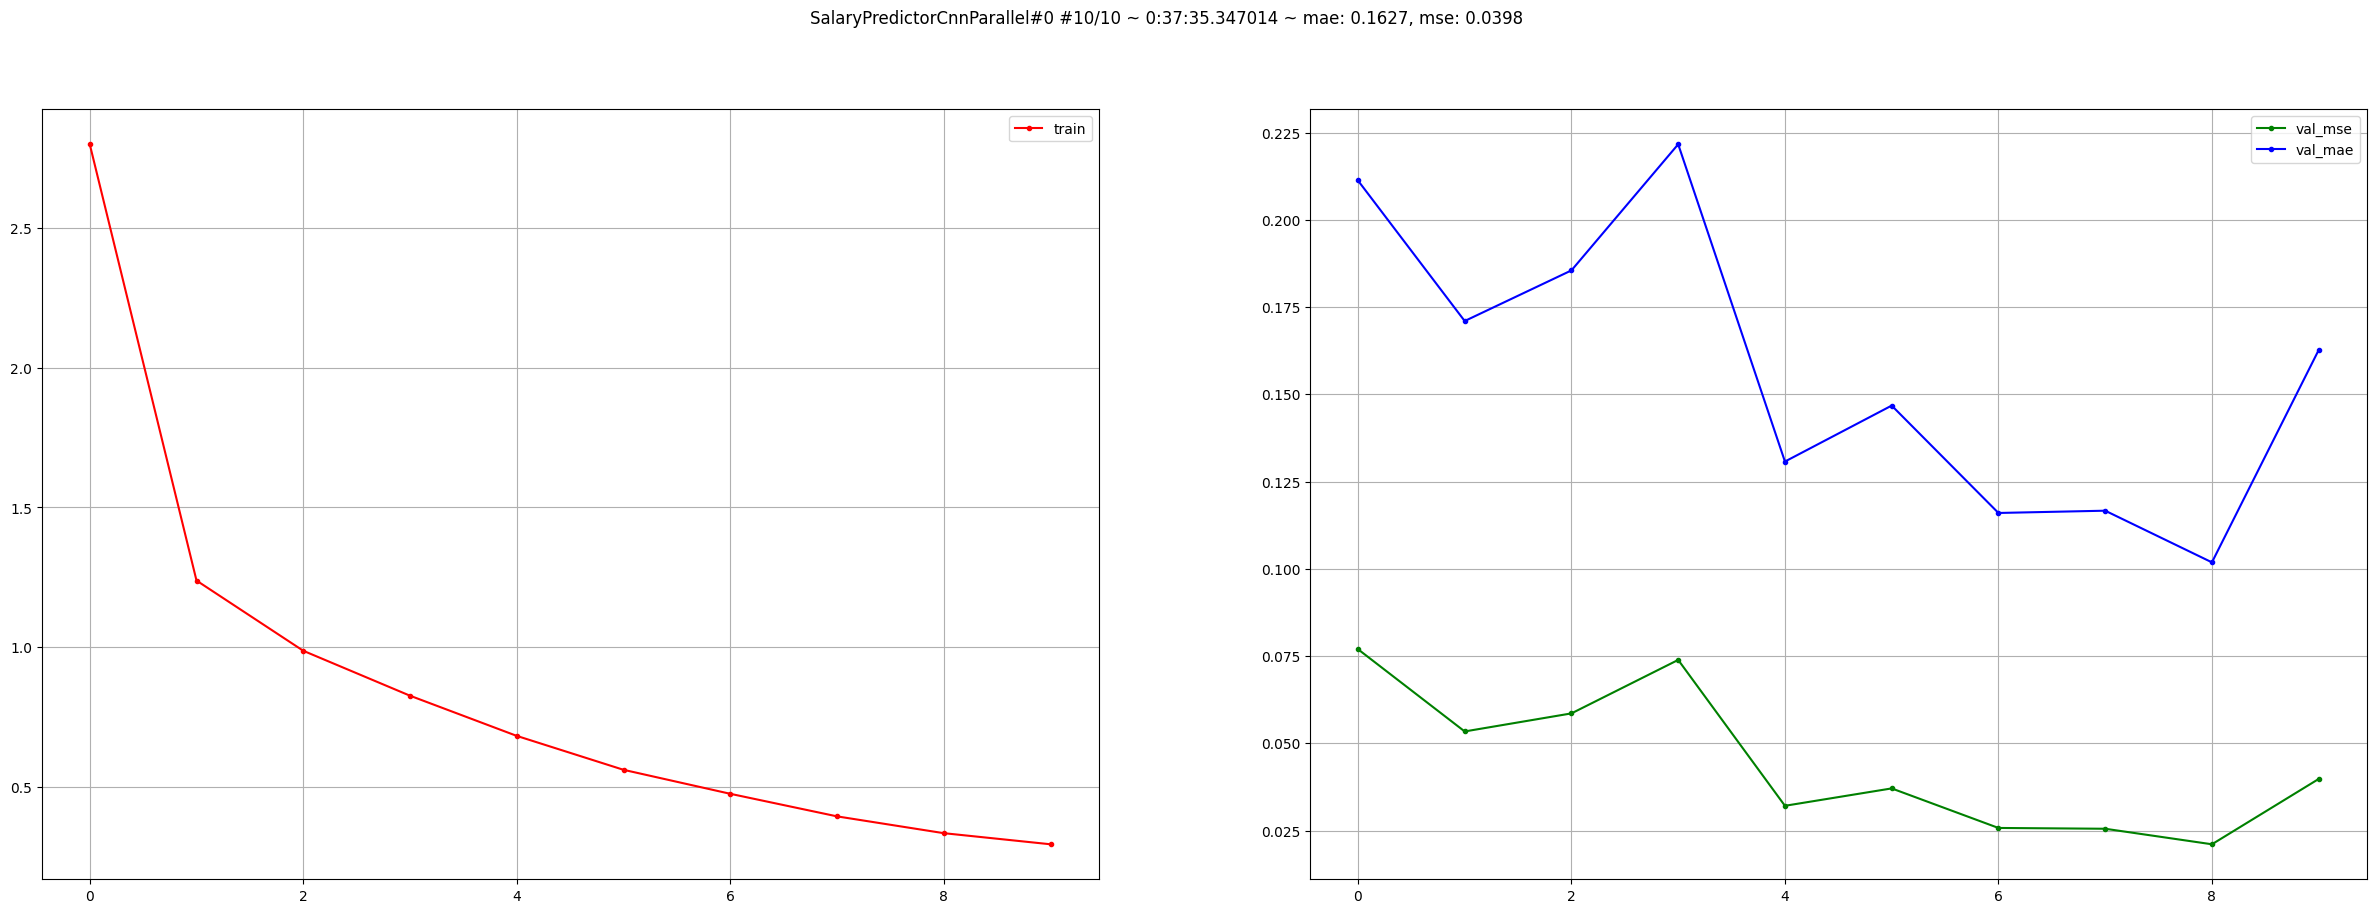

In [47]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
parallel_cnn_losses = training_loop(model, optimizer, model_name="SalaryPredictorCnnParallel")

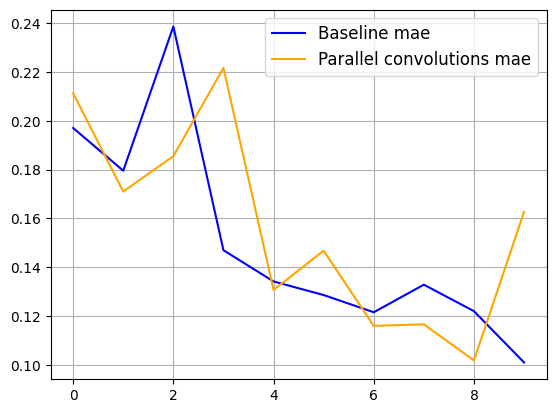

In [48]:
plt.plot(sgd_losses['test']['mae'], label='Baseline mae', color='b')
plt.plot(parallel_cnn_losses['test']['mae'], label='Parallel convolutions mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

Parallel convolutions gave no positive effect on model learning

According to plots we can assume, that due to greater number of parameters in comparison with the base model, model with parallel convolutions started to overfit faster

**Experiment 5**

Bigger network. For this we will try residual covolutional blocks (no scaling)

In [49]:
class ResConvLayer(nn.Module):
    def __init__(
        self, 
        in_channels=64,
        kernel_size=3,
        padding="same",
        activation_class=nn.ReLU,
        use_bn=False,
        p_dropout=0
    ):
        super().__init__()
        
        self.conv1 = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=in_channels,
            kernel_size=kernel_size,
            padding=padding
        )
        self.bn1 = nn.BatchNorm1d(num_features=in_channels) if use_bn else nn.Identity()
        self.activation1 = activation_class()
        
        self.conv2 = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=in_channels,
            kernel_size=kernel_size,
            padding=padding
        )
        self.bn2 = nn.BatchNorm1d(num_features=in_channels) if use_bn else nn.Identity()
        
        self.residual = nn.Sequential(
            self.conv1,
            self.bn1,
            self.activation1,
            self.conv2,
            self.bn2
        )
        
        self.activation2 = activation_class()
        self.dropout = nn.Dropout(p=p_dropout)
        
    def forward(self, batch, *args, **kwargs):
        x = self.residual(batch)
        x = x + batch
        x = self.dropout(x)
        x = self.activation2(x)
        return x

In [50]:
class TextEncoderRes(nn.Module):
    def __init__(
        self, 
        n_tokens=len(tokens),
        embedding_dim=100,
        out_channels=128,
        kernel_size=3,
        padding="same",
        activation_class=nn.ReLU,
        pooling_class=MaxOverTimePooling,
        use_bn=False,
        p_dropout=0
    ):
        super().__init__()

        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=embedding_dim,
            padding_idx=PAD_IX
        )
        self.conv1 = ResConvLayer(
            in_channels=embedding_dim, 
            kernel_size=kernel_size,
            padding=padding,
            activation_class=activation_class,
            use_bn=use_bn,
            p_dropout=p_dropout
        )
        self.conv2 = ResConvLayer(
            in_channels=embedding_dim, 
            kernel_size=kernel_size,
            padding=padding,
            activation_class=activation_class,
            use_bn=use_bn,
            p_dropout=p_dropout
        )
        self.pool = pooling_class()

    def forward(self, batch, *args, **kwargs):
        emb = self.emb(batch).swapaxes(1, 2)
        x = self.conv1(emb)
        x = self.conv2(x)
        return self.pool(x)

In [51]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params["use_bn"] = True

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params["use_bn"] = True

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoderRes,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoderRes,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("embedding_dim", 128) + 
        description_encoder_params.get("embedding_dim", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

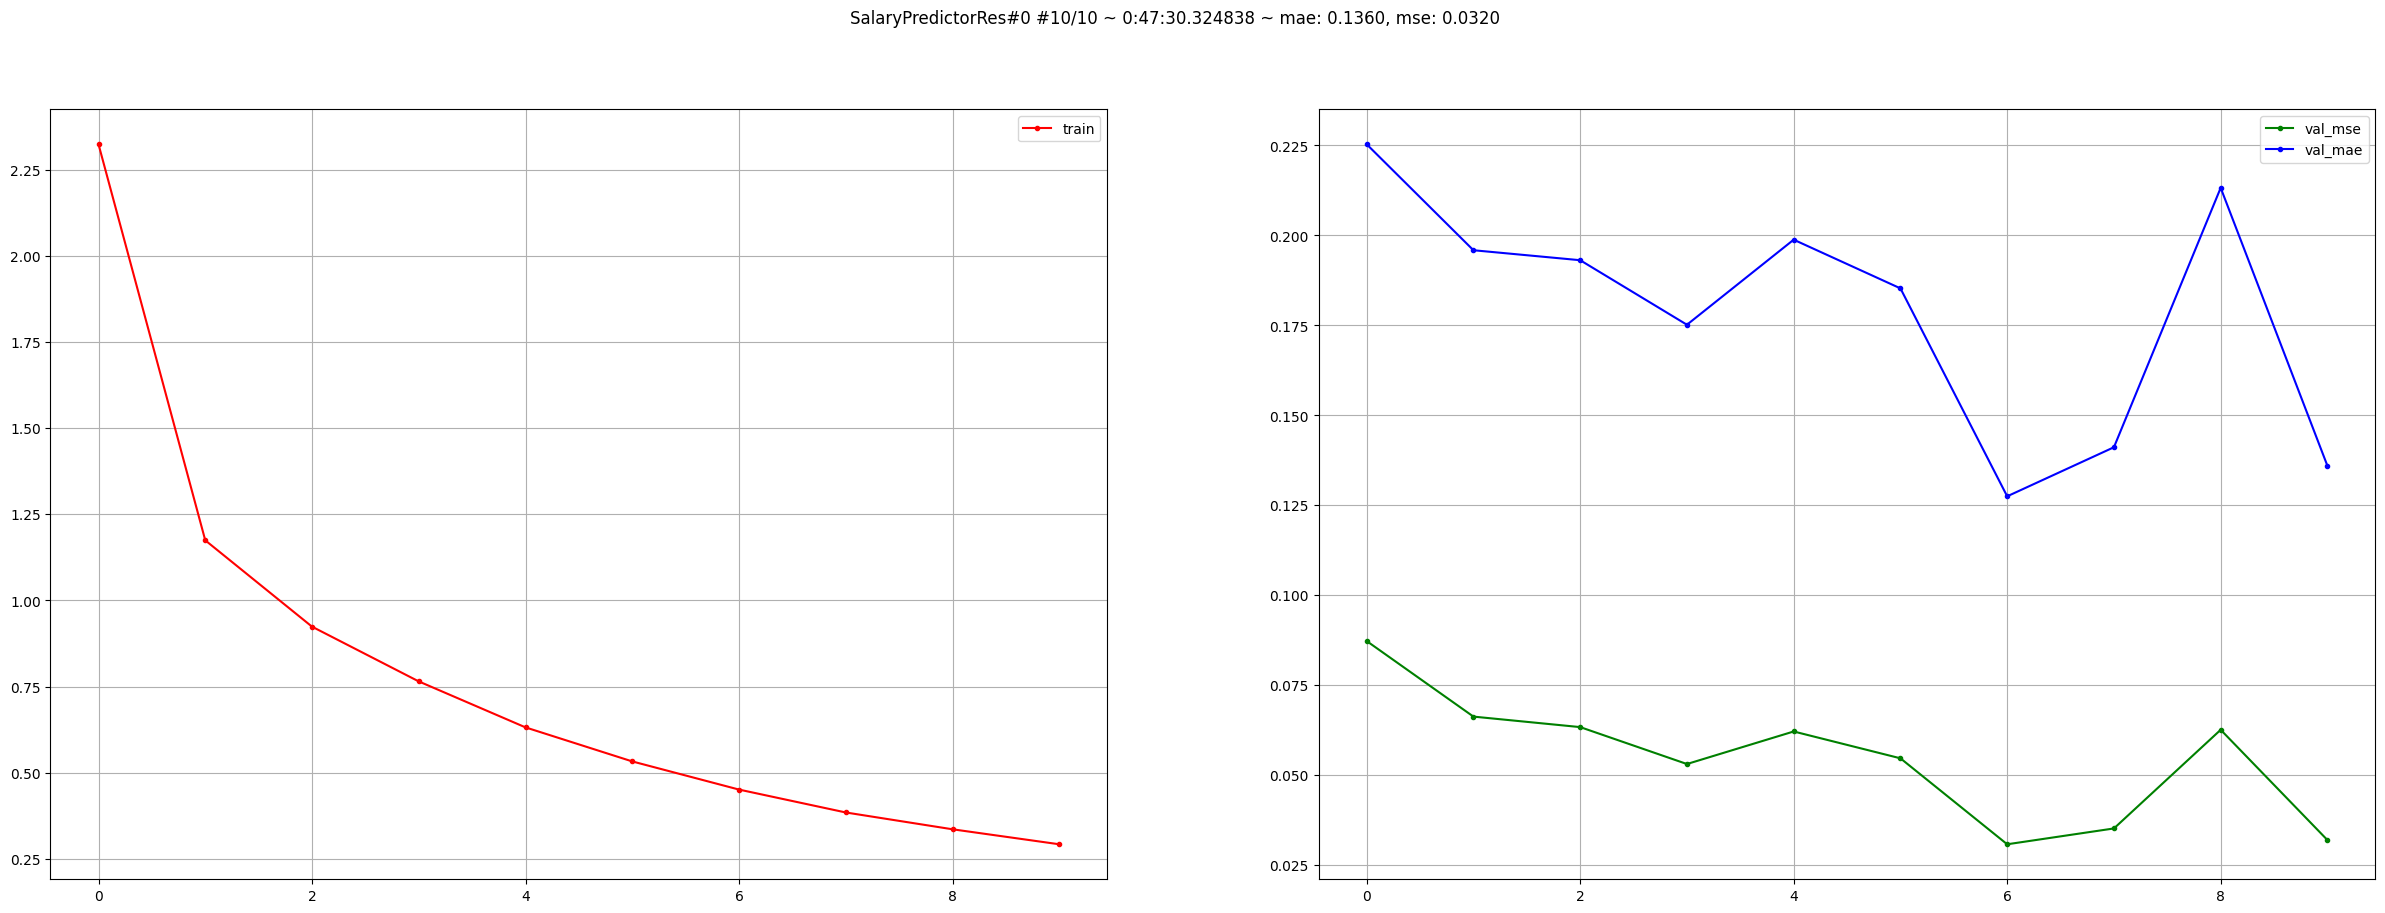

In [52]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
res_losses = training_loop(model, optimizer, model_name="SalaryPredictorRes")

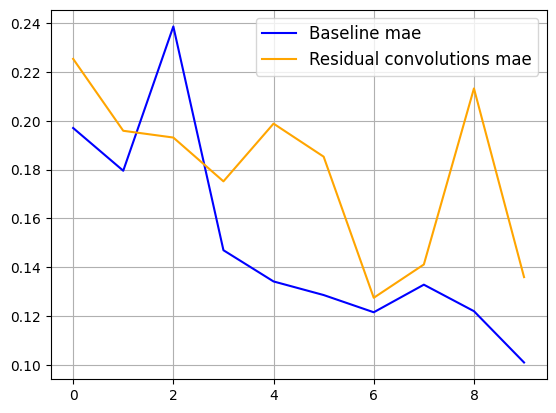

In [53]:
plt.plot(sgd_losses['test']['mae'], label='Baseline mae', color='b')
plt.plot(res_losses['test']['mae'], label='Residual convolutions mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

Like in previous experiment we can notice only increase in model learning time, but not in model quality. Overfitting is even more obvious, then in previous experiment due to even greater increase in parameters number

In [28]:
# checkpoint
import pickle

def pickle_results(results, name):
    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickled_results(name):
    with open(name + '.pickle', 'rb') as handle:
        result = pickle.load(handle)
        return result

In [39]:
# pickle_results(sgd_losses, 'sgd_losses')
sgd_losses = load_pickled_results('/kaggle/input/pickled/pickled/sgd_losses')

**Experiment 6**

1. Avearge over time pooling

2. Softmax pooling 

3. Attentive pooling

In [63]:
class AverageOverTimePooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, weights, *args, **kwargs):
        mask = weights != 0
        eps = 1e-9
        return weights.sum(dim=-1) / (mask.sum(dim=-1)  + eps)

In [64]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['pooling_class'] = AverageOverTimePooling

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['pooling_class'] = AverageOverTimePooling

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channles", 128) + 
        description_encoder_params.get("out_channles", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

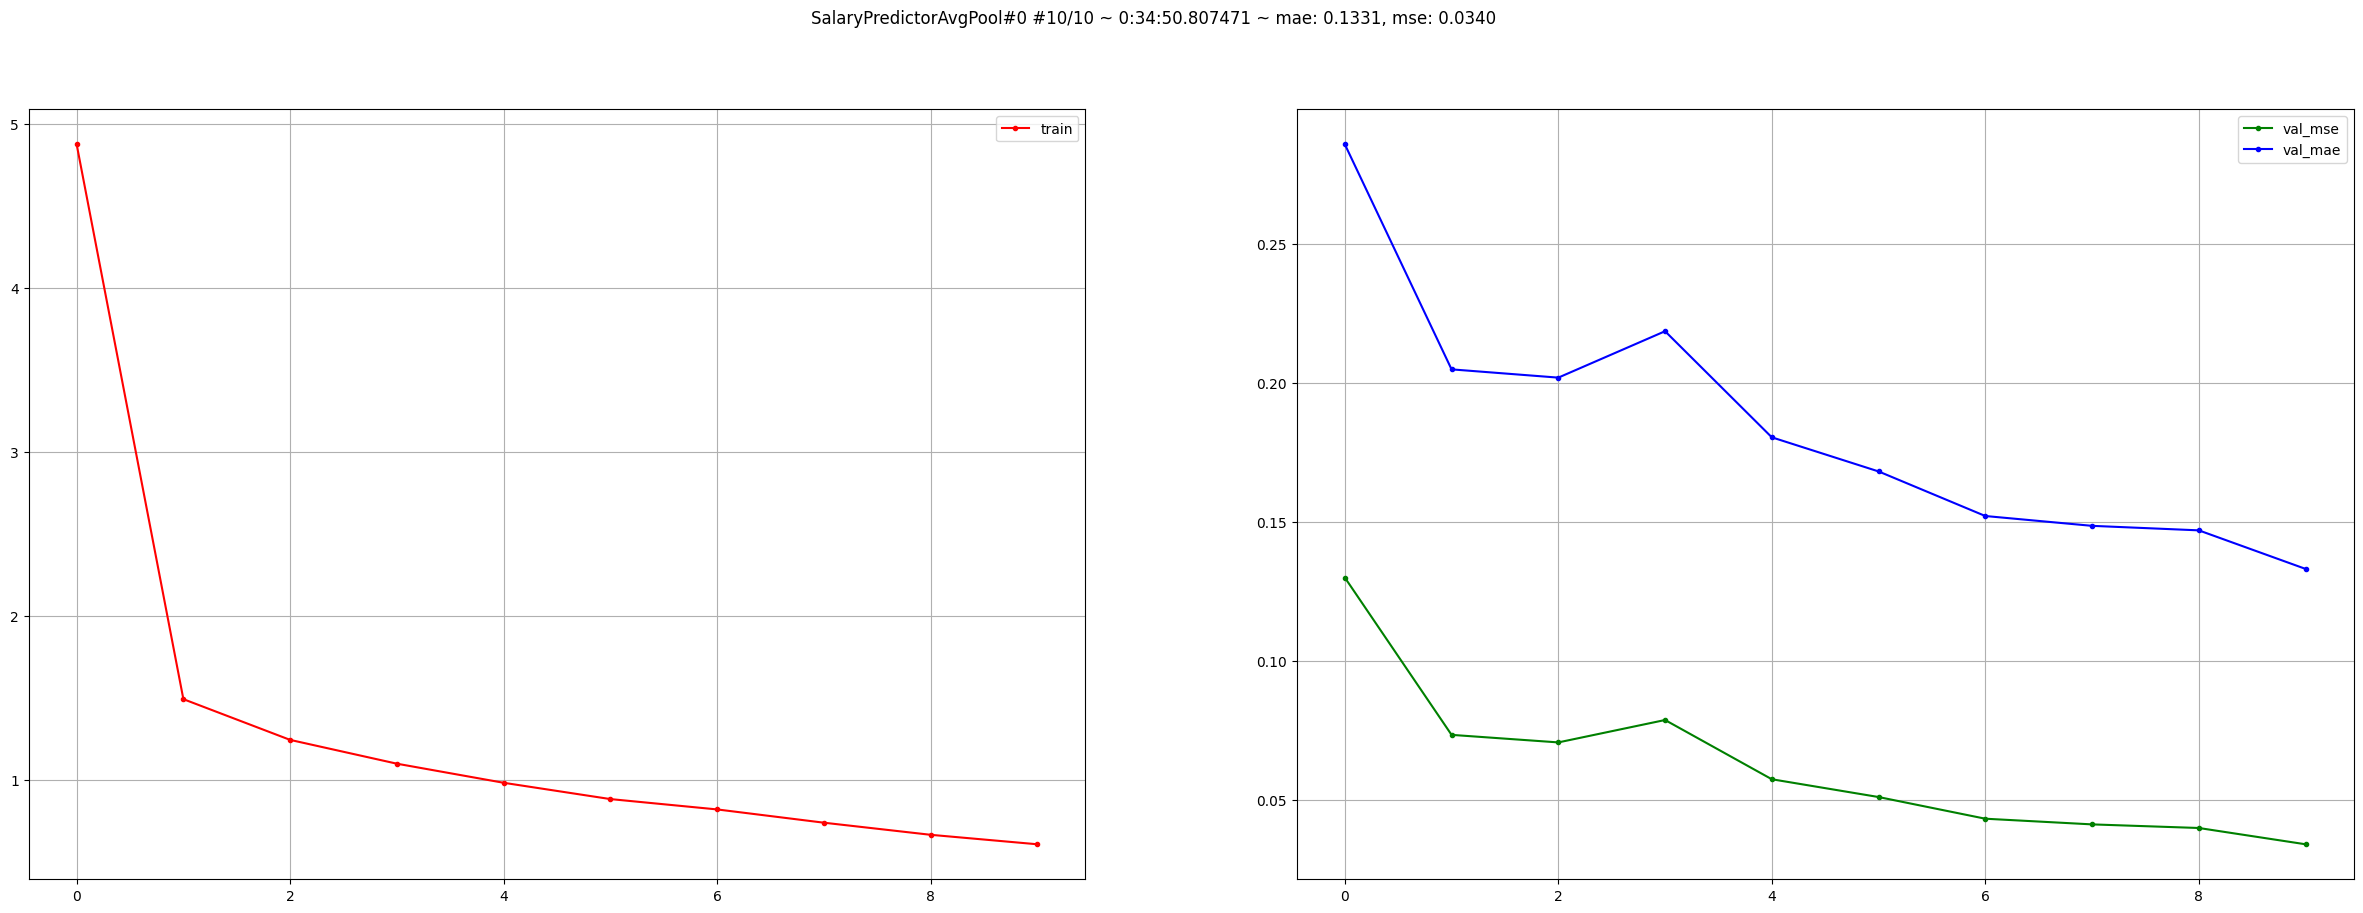

In [65]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
avg_pool_losses = training_loop(model, optimizer, model_name="SalaryPredictorAvgPool")

In [30]:
class SoftmaxPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, weights, *args, **kwargs):
        exp = torch.exp(weights)
        numerator = weights * exp
        return numerator.sum(dim=-1) / exp.sum(dim=-1)

In [31]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['pooling_class'] = SoftmaxPooling

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['pooling_class'] = SoftmaxPooling

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channles", 128) + 
        description_encoder_params.get("out_channles", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

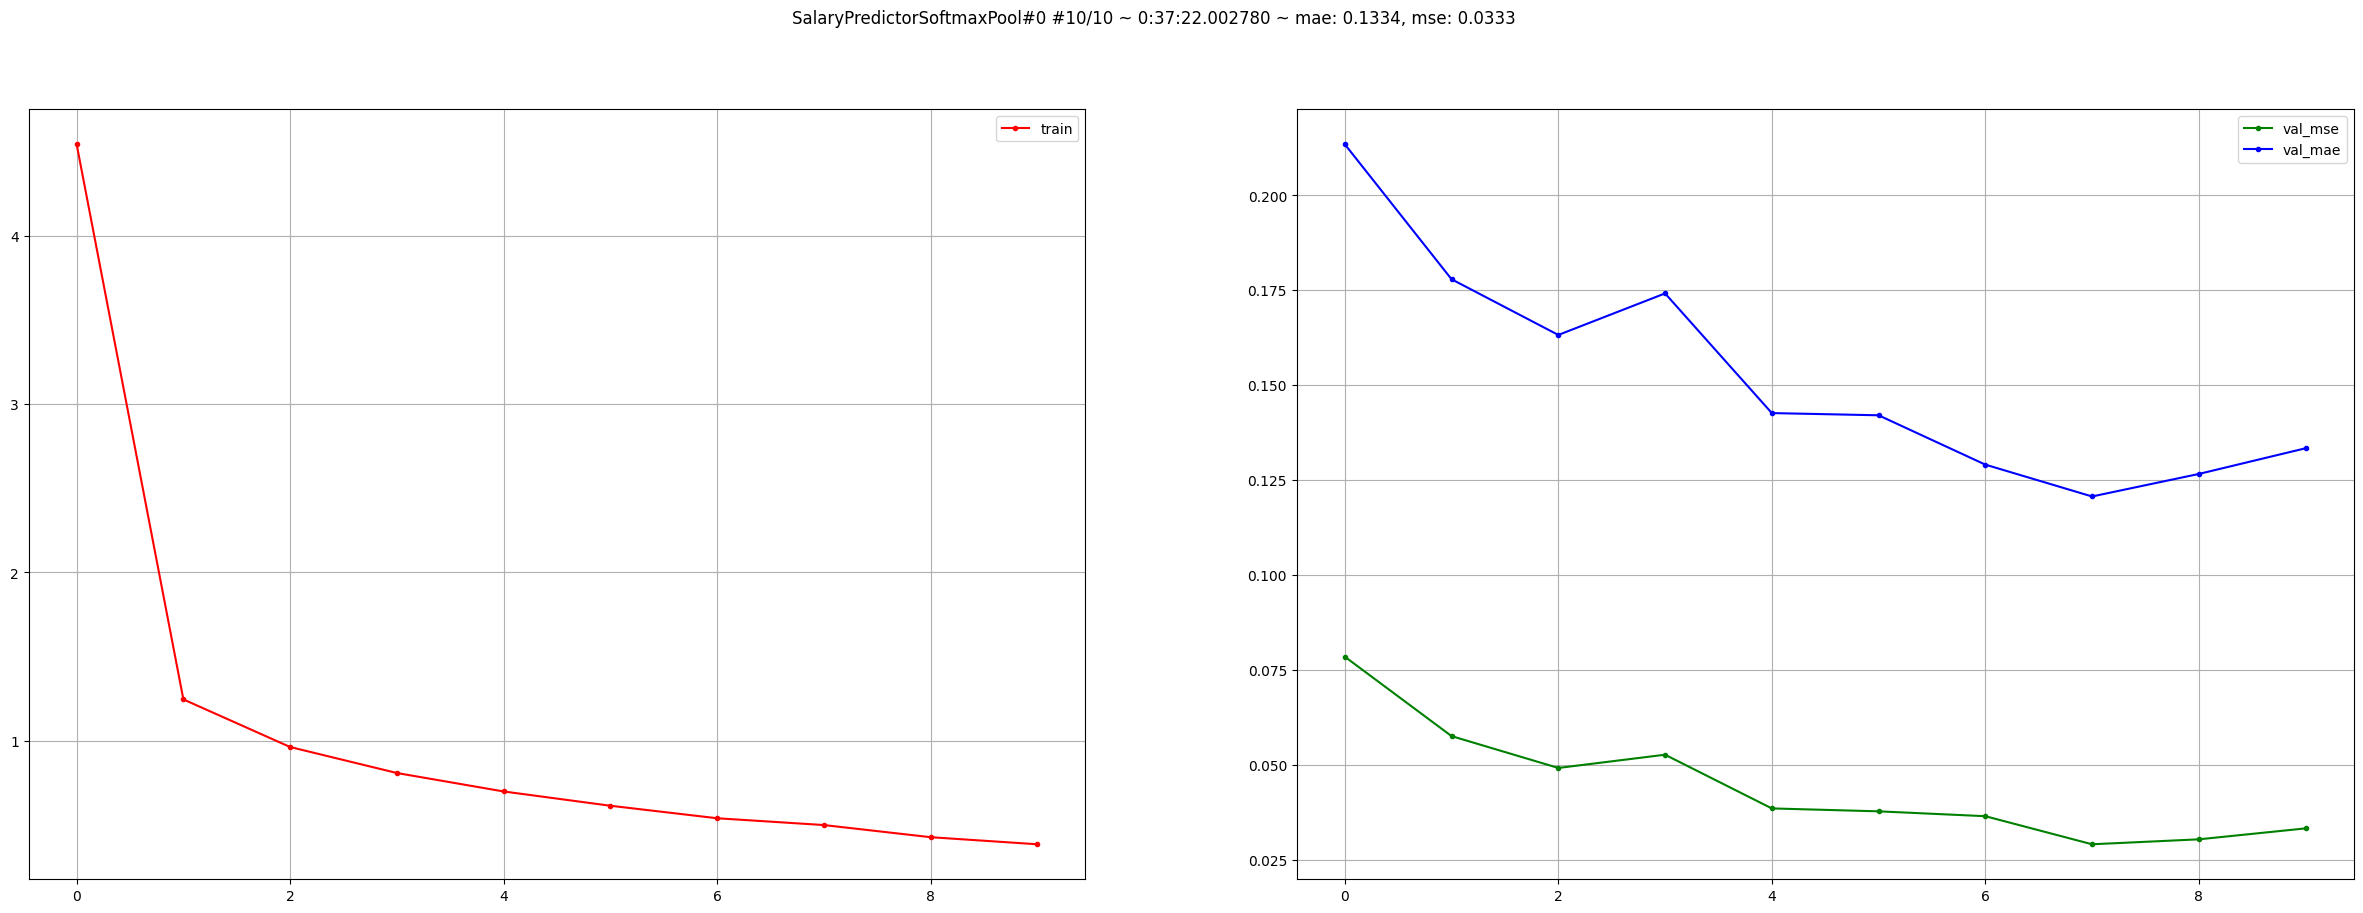

In [32]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
softmax_pool_losses = training_loop(model, optimizer, model_name="SalaryPredictorSoftmaxPool")

In [40]:
class AttentivePooling(nn.Module):
    def __init__(self, input_size=128):
        super().__init__()
        self.fc = nn.Linear(input_size, input_size)
        self.activation = nn.Tanh()

    def forward(self, weights, *args, **kwargs):
        w = weights.swapaxes(1,2)
        attn = self.activation(self.fc(w)).swapaxes(1,2)
        exp = torch.exp(attn)
        numerator = weights * exp
        return numerator.sum(dim=-1) / exp.sum(dim=-1)

In [41]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['pooling_class'] = AttentivePooling

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['pooling_class'] = AttentivePooling

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoder,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoder,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channles", 128) + 
        description_encoder_params.get("out_channles", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

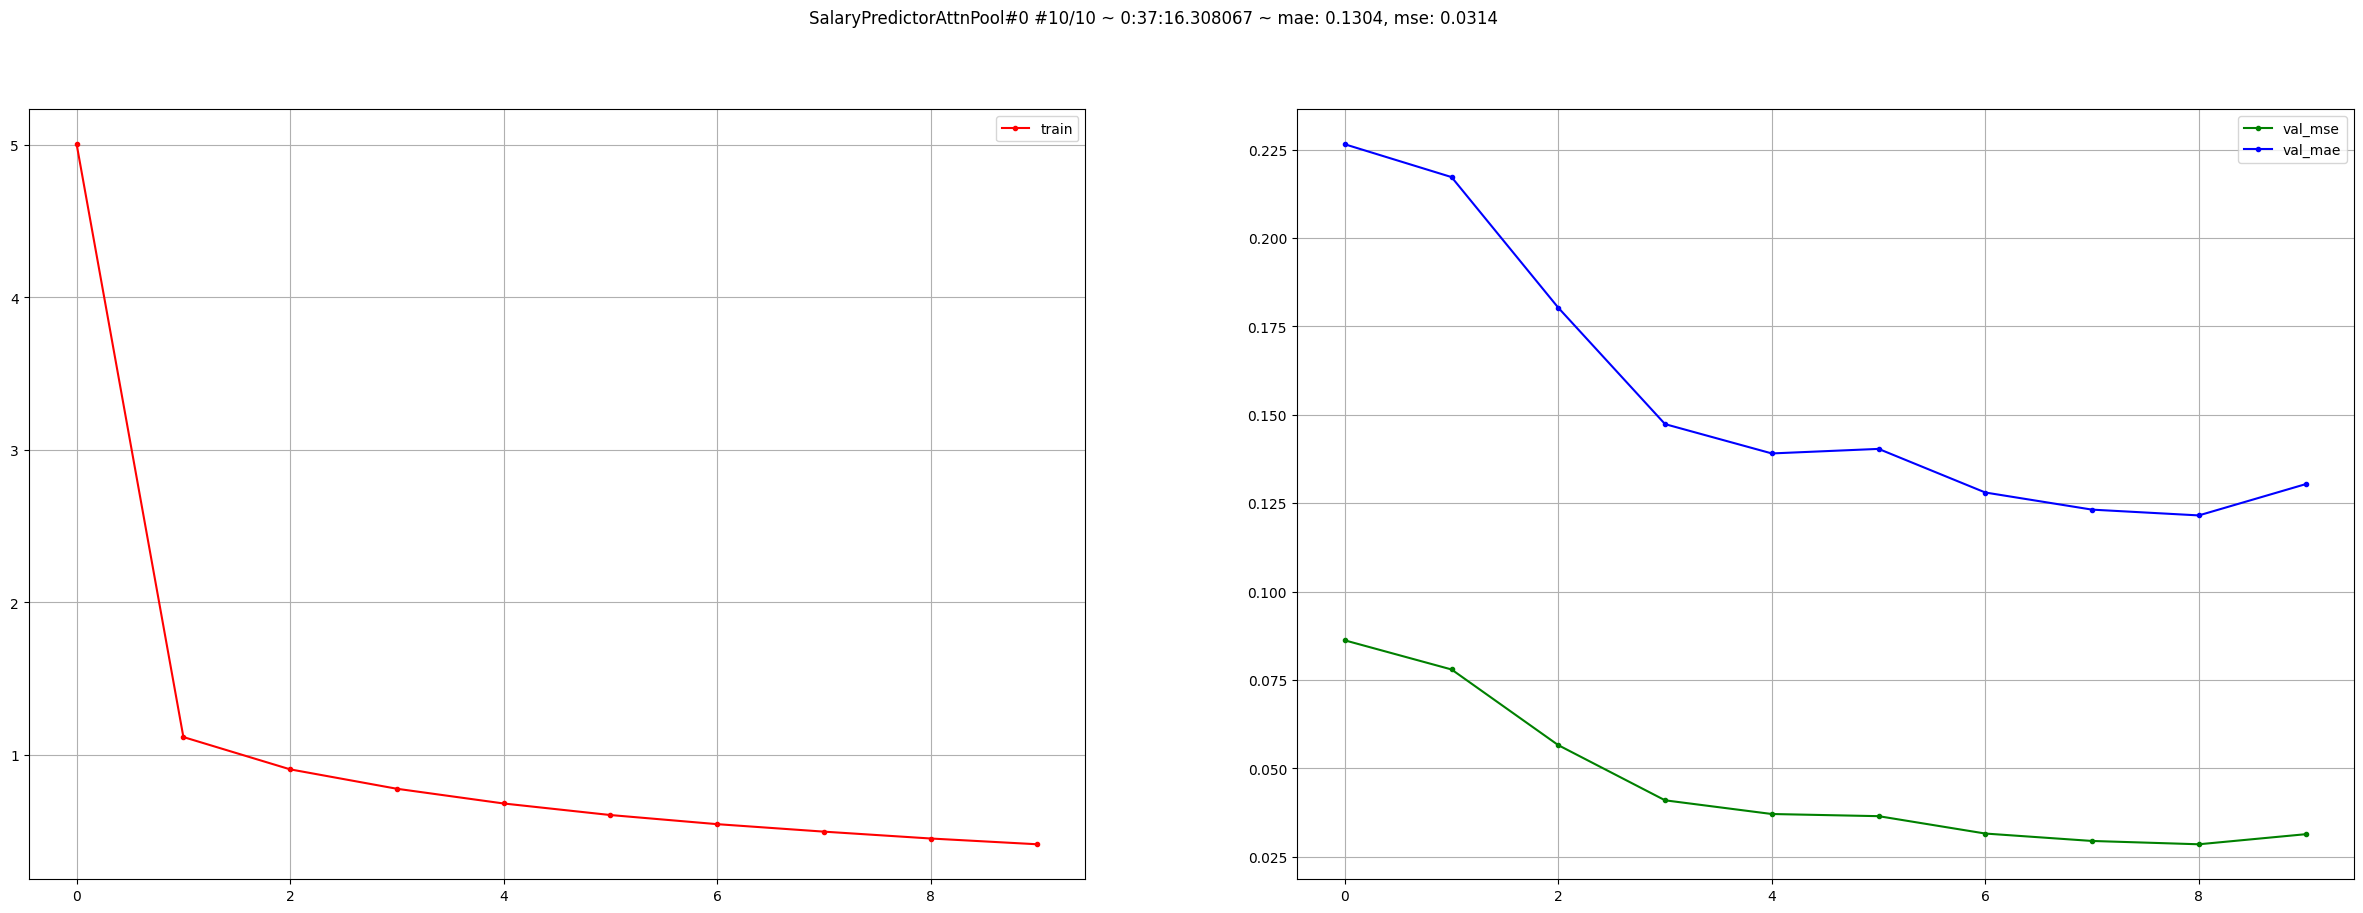

In [42]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
attn_pool_losses = training_loop(model, optimizer, model_name="SalaryPredictorAttnPool")

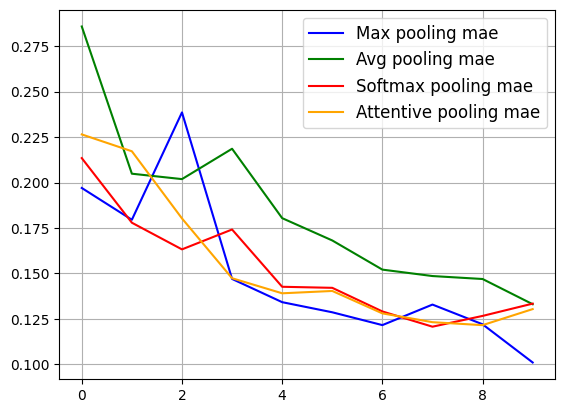

In [43]:
plt.plot(sgd_losses['test']['mae'], label='Max pooling mae', color='b')
plt.plot(avg_pool_losses['test']['mae'], label='Avg pooling mae', color='g')
plt.plot(softmax_pool_losses['test']['mae'], label='Softmax pooling mae', color='r')
plt.plot(attn_pool_losses['test']['mae'], label='Attentive pooling mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

All poolings except average over time pooling worked quite well

**Experiment 7**

1. Pretrained embeddings (frozen weights)

2. Pretrained embeddings (unfrozen weights)

3. Same embedding matrix for title and description

In [44]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-09-28 07:31:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2024-09-28 07:33:57 (5.18 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [45]:
path_to_glove_file = "/kaggle/working/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [46]:
EMBEDDING_DIM = 100

In [47]:
pretrained_weights = np.random.standard_normal(size=(len(tokens), EMBEDDING_DIM))

hits, misses = 0, 0 
for token, idx in token_to_id.items():
    embedding_vector = embeddings_index.get(token)
    if embedding_vector is not None:
        pretrained_weights[idx] = embedding_vector
        hits += 1
    else:
        misses += 1

pretrained_weights[PAD_IX] = np.zeros(100, dtype=np.float64)
print("Converted %d words (%d misses)" % (hits, misses))

Converted 26223 words (7935 misses)


In [48]:
class TextEncoderPretrained(nn.Module):
    def __init__(
        self, 
        n_tokens=len(tokens),
        embedding_dim=100,
        out_channels=128,
        kernel_size=3,
        padding="same",
        activation_class=nn.ReLU,
        pooling_class=MaxOverTimePooling,
        use_bn=False,
        p_dropout=0,
        requires_grad=False
    ):
        super().__init__()

        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=embedding_dim,
            padding_idx=PAD_IX
        )
        self.emb.weight = nn.Parameter(
            torch.from_numpy(pretrained_weights).to(dtype=self.emb.weight.dtype),
            requires_grad=requires_grad,
        )
        self.conv = ConvLayer(
            in_channels=embedding_dim, 
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            activation_class=activation_class,
            pooling_class=pooling_class,
            use_bn=use_bn,
            p_dropout=p_dropout
        )

    def forward(self, batch, *args, **kwargs):
        emb = self.emb(batch).swapaxes(1, 2)
        x = self.conv(emb)
        return x

In [82]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['requires_grad'] = False

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['requires_grad'] = False

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoderPretrained,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoderPretrained,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channles", 128) + 
        description_encoder_params.get("out_channles", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

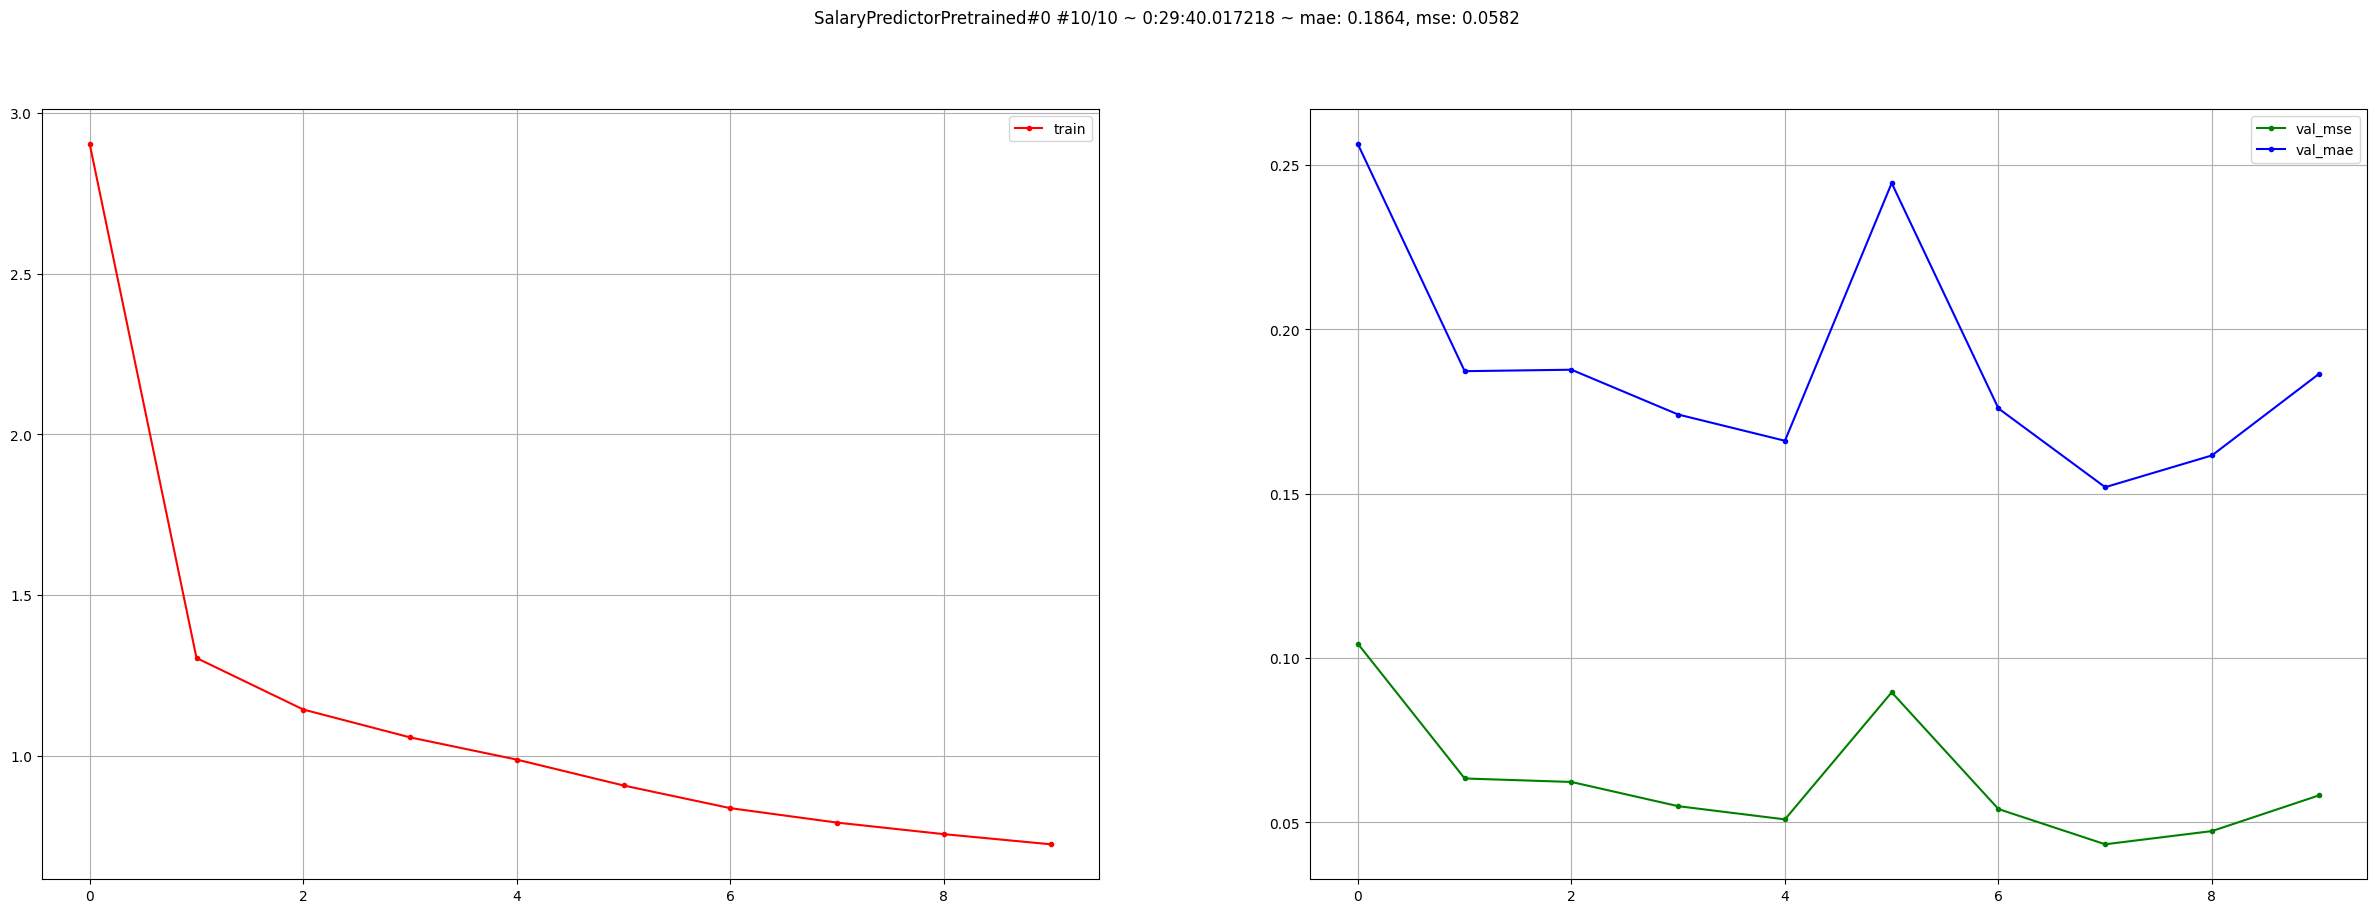

In [83]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
pretrained_losses = training_loop(model, optimizer, model_name="SalaryPredictorPretrained")

In [84]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['requires_grad'] = True

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['requires_grad'] = True

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoderPretrained,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoderPretrained,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channles", 128) + 
        description_encoder_params.get("out_channles", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": False
}

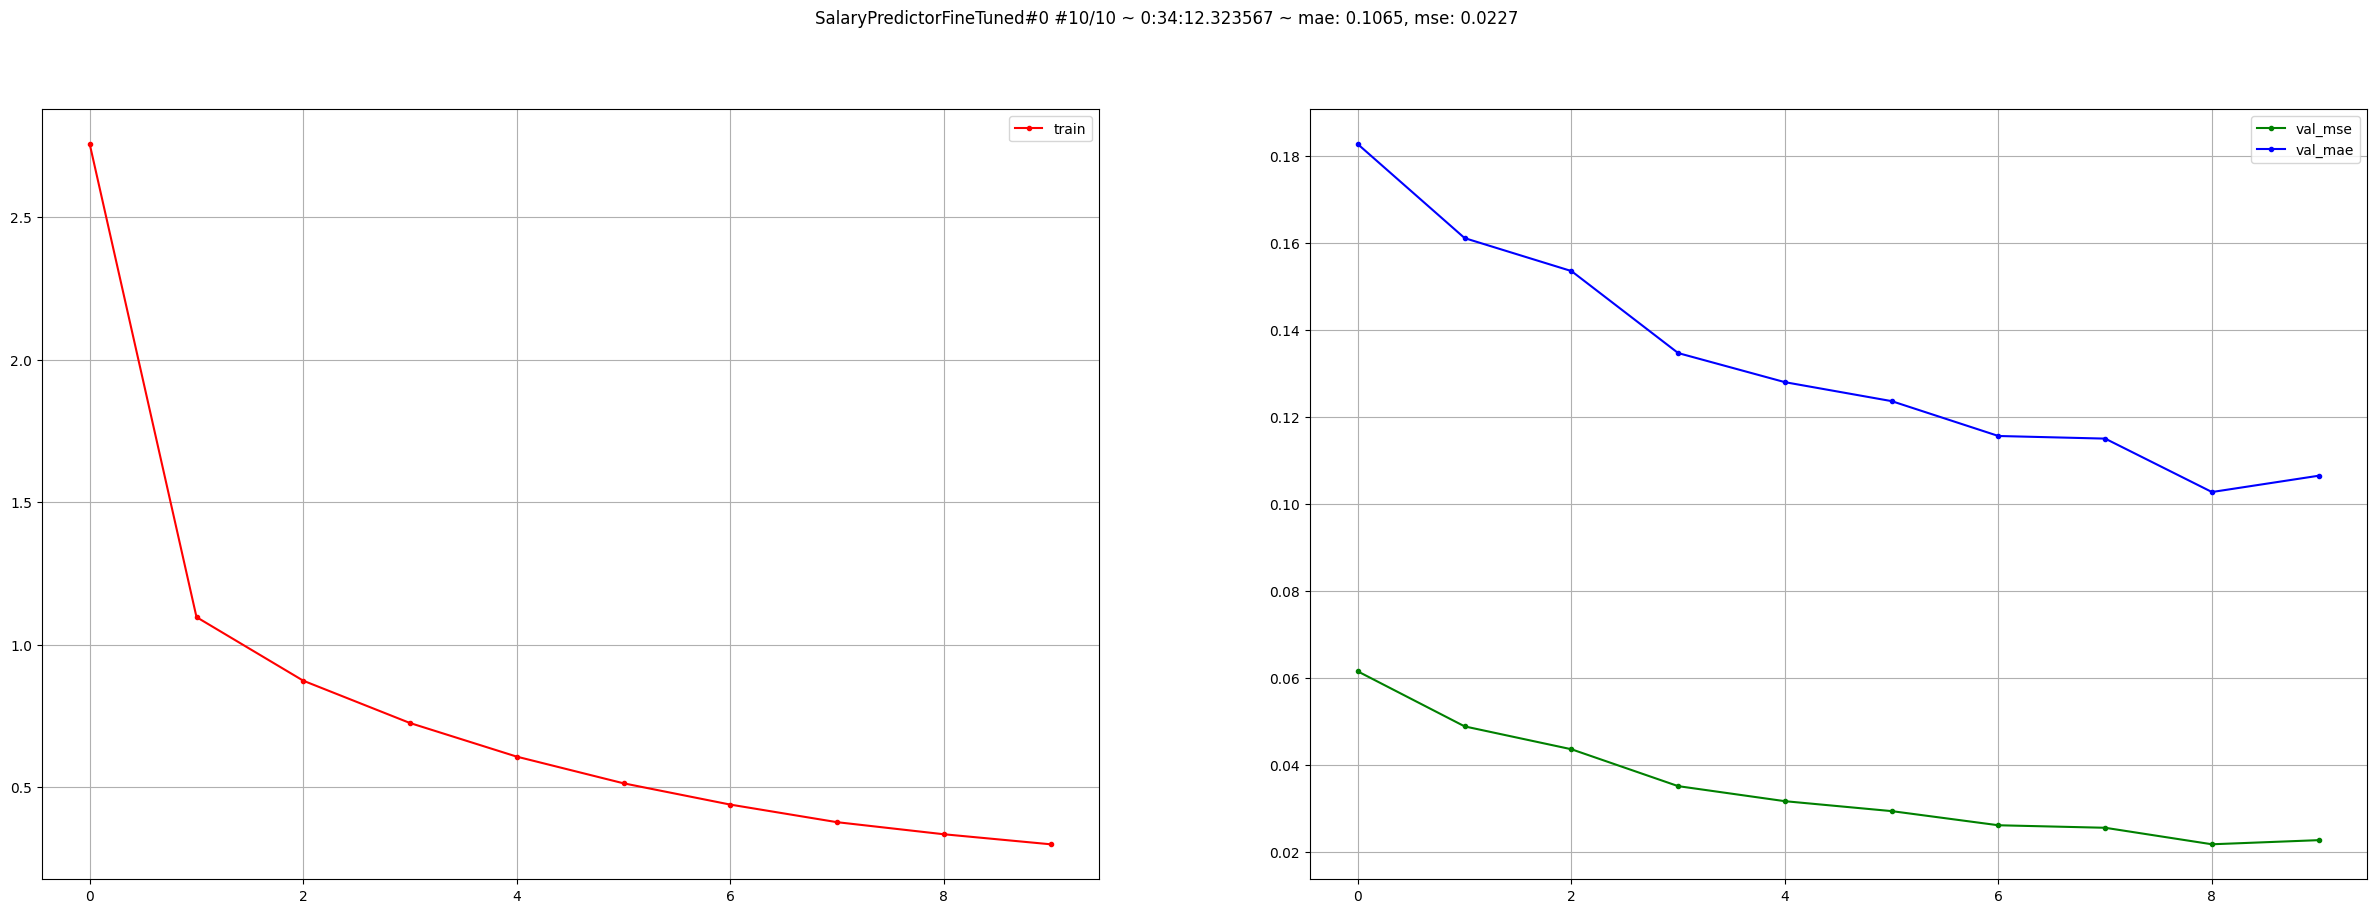

In [85]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
fine_tuned_losses = training_loop(model, optimizer, model_name="SalaryPredictorFineTuned")

In [86]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['requires_grad'] = True

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['requires_grad'] = True

categorical_encoder_params = {
    **default_categorical_encoder_params
}

model_params = {
    "title_encoder_class": TextEncoderPretrained,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoderPretrained,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channles", 128) + 
        description_encoder_params.get("out_channles", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0,
    "use_same_embeddings": True
}

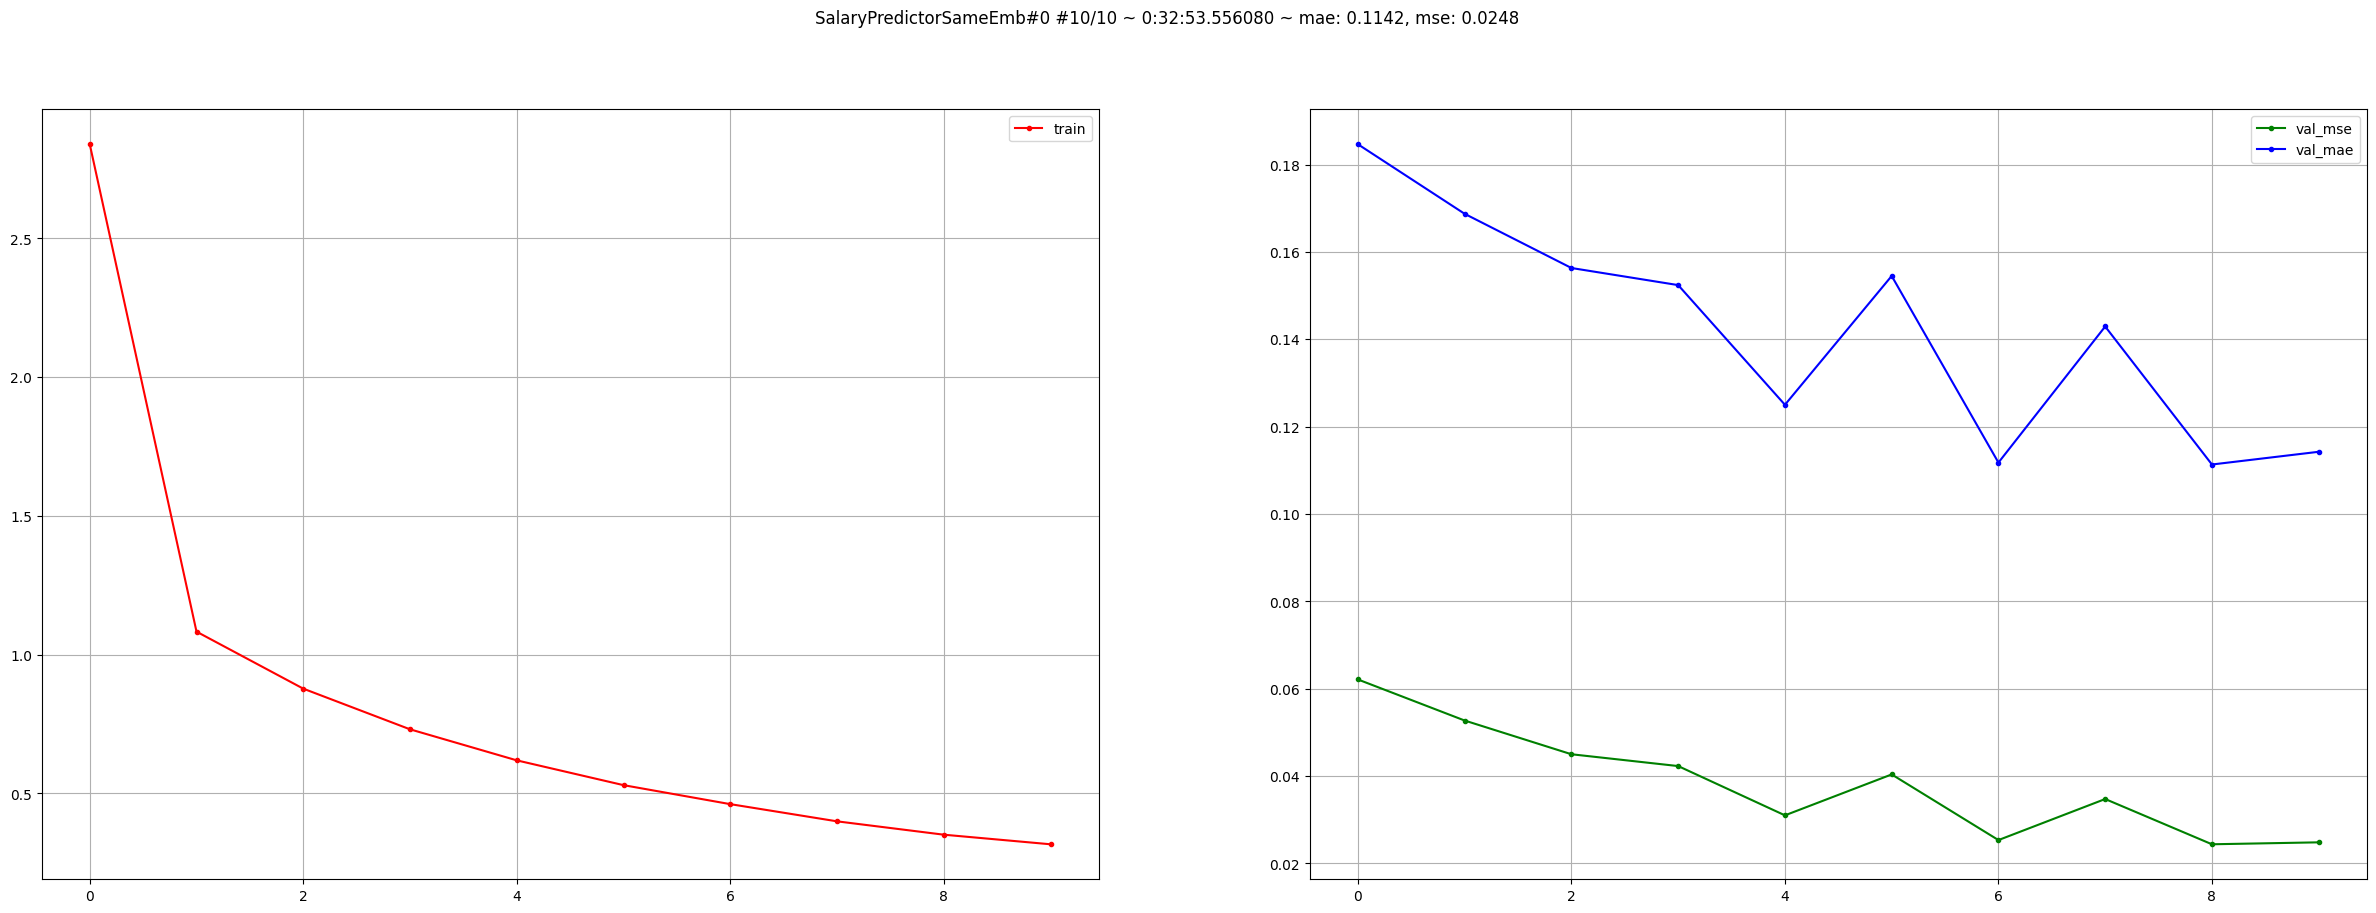

In [87]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
same_emb_losses = training_loop(model, optimizer, model_name="SalaryPredictorSameEmb")

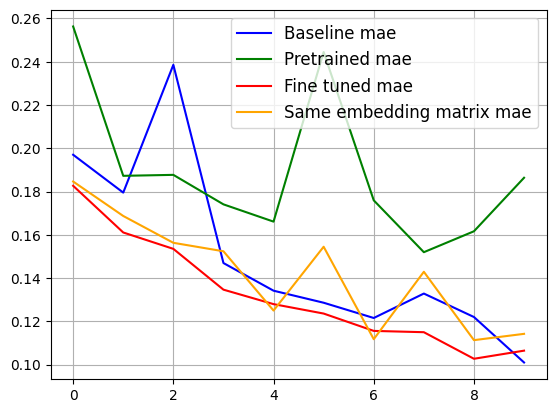

In [88]:
plt.plot(sgd_losses['test']['mae'], label='Baseline mae', color='b')
plt.plot(pretrained_losses['test']['mae'], label='Pretrained mae', color='g')
plt.plot(fine_tuned_losses['test']['mae'], label='Fine tuned mae', color='r')
plt.plot(same_emb_losses['test']['mae'], label='Same embedding matrix mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

Using pretrained embeddings without fine tuning was not beneficial

On contrary pretrained embeddings with fine tuning worked very well

Using same embedding matrix for title and decription in conjunction with fine tuining has not improved model quality

**Experiment 8 - Best from both worlds**

Let's combine tricks from different experiments and see what we can achieve

We will use

1. Dropout in Dense layers
2. BatchNorm in CNN layers
3. Pretrained embeddings with fine tuning
4. Increase number of epochs to 15
5. MaxOverTimePooling

In [49]:
title_encoder_params = {
    **default_title_encoder_params
}
title_encoder_params['requires_grad'] = True
title_encoder_params['use_bn'] = True

description_encoder_params = {
    **default_description_encoder_params
}
description_encoder_params['requires_grad'] = True
description_encoder_params['use_bn'] = True

categorical_encoder_params = {
    **default_categorical_encoder_params
}
categorical_encoder_params['p_dropout'] = 0.3

model_params = {
    "title_encoder_class": TextEncoderPretrained,
    "title_encoder_params": title_encoder_params,
    "description_encoder_class": TextEncoderPretrained,
    "description_encoder_params": description_encoder_params,
    "categorical_encoder_class": CategoricalEncoder,
    "categorical_encoder_params": categorical_encoder_params,
    "input_size": (
        title_encoder_params.get("out_channles", 128) + 
        description_encoder_params.get("out_channles", 128) +
        categorical_encoder_params.get("out_size", 128)
    ),
    "hid_size": 64,
    "activation_class" : nn.ReLU,
    "use_bn" : False,
    "p_dropout" : 0.3,
    "use_same_embeddings": False
}

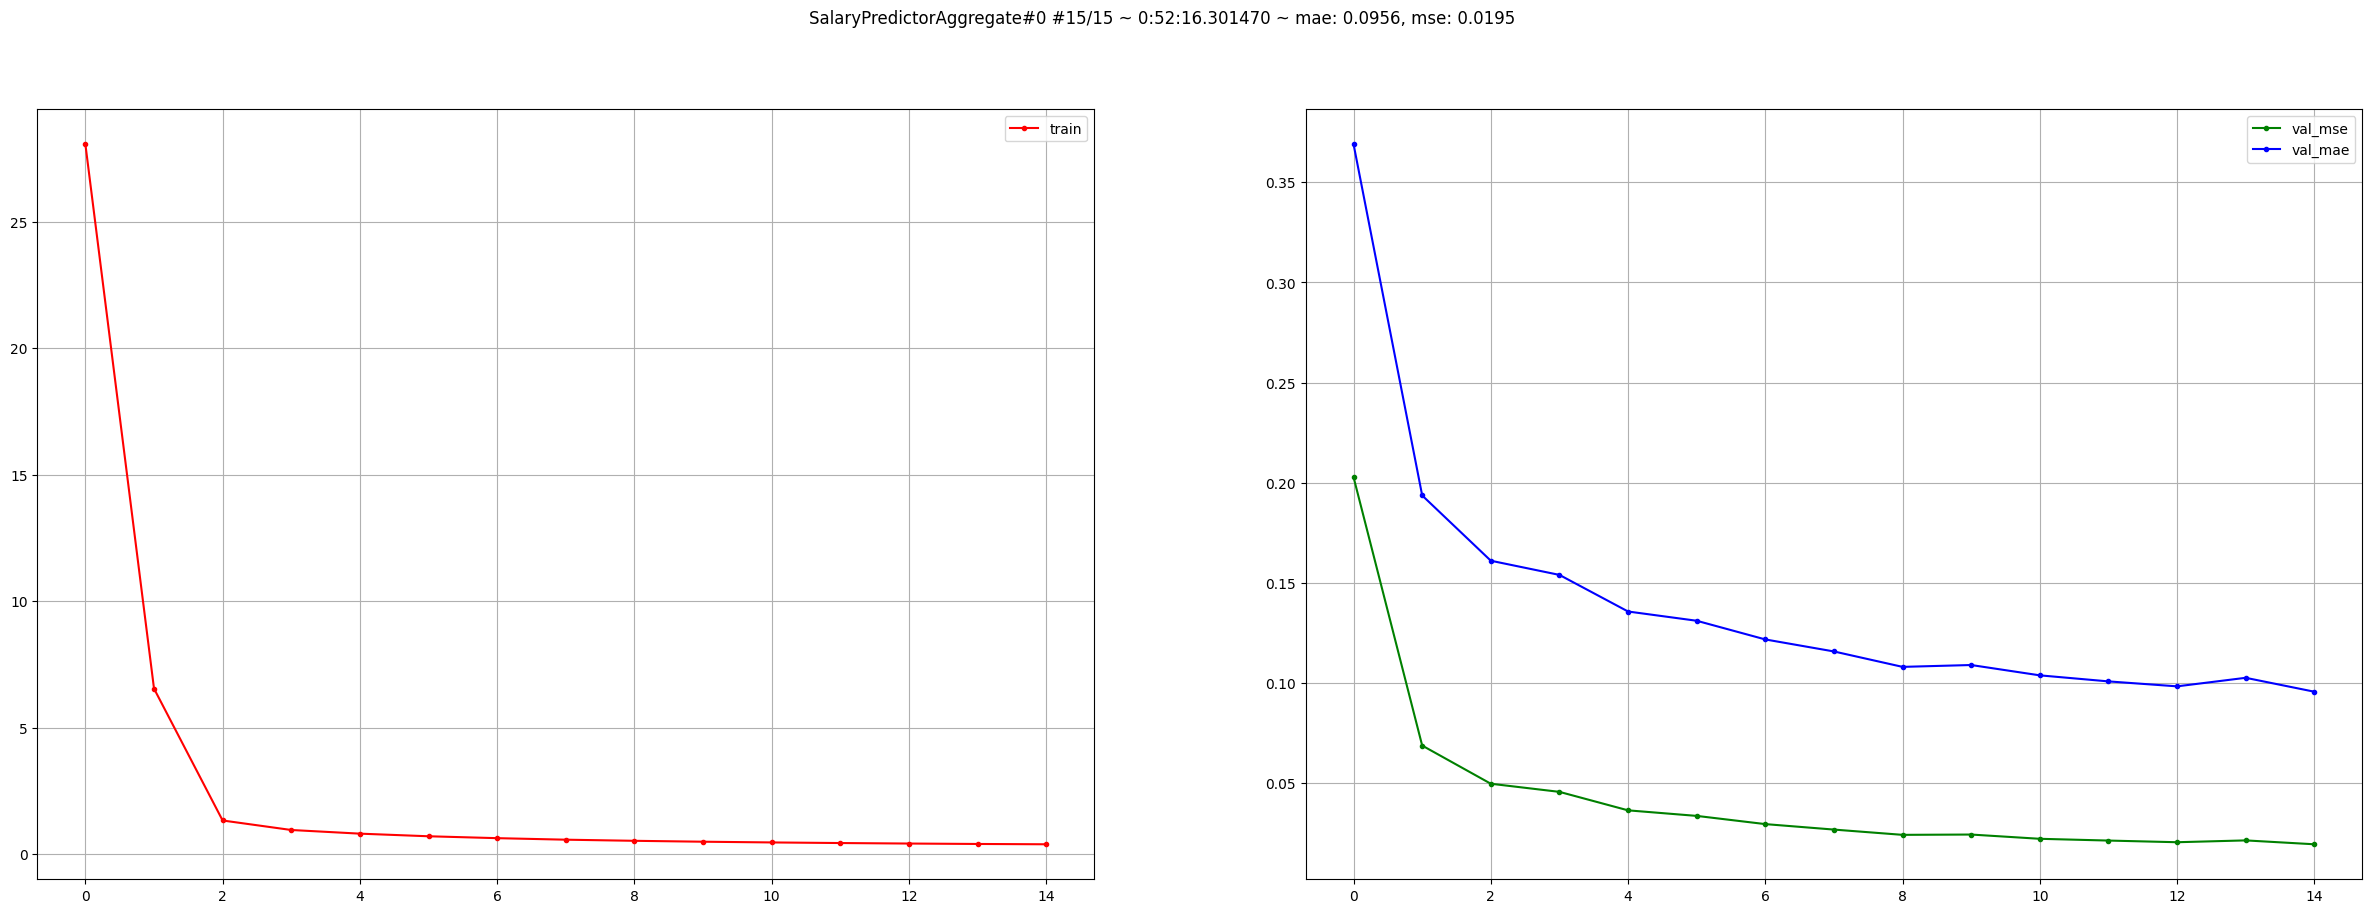

In [50]:
model, optimizer = create_mode_and_optimizer(
    SalaryPredictor, 
    model_params
)
aggregate_losses = training_loop(model, optimizer, model_name="SalaryPredictorAggregate", epochs=15)

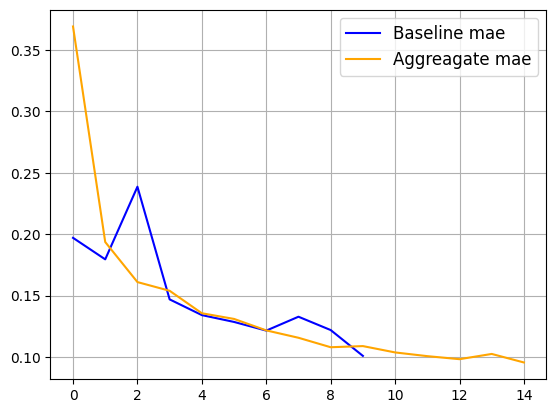

In [51]:
plt.plot(sgd_losses['test']['mae'], label='Baseline mae', color='b')
plt.plot(aggregate_losses['test']['mae'], label='Aggreagate mae', color='orange')
plt.legend(fontsize='large')
plt.grid()
plt.show()

This was our best model. We've managed to achieve
- 0.0956 mae
- 0.0195 mse

### A short report

Please tell us what you did and how did it work.

First we've prepared clasees and methods, that allowed us to perform experiments more easily, by allowing us
1. Use early stoping
2. Saving best model version
3. Plotting learning curves

We've conducted 8 experiments

1. SGD vs Adam optimizer. SGD optimizer ended up with more noisy learning plots, but validation metrics were higher

2. Dropout
- In CNN layer
- In Dense layer

In our case using Dropout in CNN was not a good idea. On contrary dropout in dense layers was quite beneficial

3. Batch Normalization
- In CNN layer
- In Dense layer

We've conducted, that BN layers are better suited for use with CNN layers

4. Parallel convolutions on same embeddings. No increase in validation metrics. Faster overfitting

5. Bigger network (we've implemented residual layers). No increase in validaiton metrics. Even faster overfitting

6. Pooling
- Average over time
- Softmax pooling
- Attentive pooling

All pooling versions worked quite well, but deafult max over time pooling gave best results

7. Embeddings
- Pretrained embeddings (no fine tuning)
- Preatrained embeddings (with fine tuning)
- Fine tuning with same embedding matrix for title and description

Fine tuning gave best results

8. Putting it all together

For our final experiment for best results we used
- Dropout in Dense layers
- BatchNorm in CNN layers
- Pretrained embeddings with fine tuning
- Increase number of epochs to 15
- MaxOverTimePooling

Final results
- 0.0956 mae
- 0.0195 mse


## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!